In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

<font color=blue>
<h1 style="font-size:2.5vw">Take Home Project</h1>
</font>

By: Vahid "Zach" Golkhou, PhD

# Subject: Enron Emails Analysis

> Dataset: I downloded a cleaned up version of a subset of the Enron emails from the following link: https://www.kaggle.com/loryn808/truncated-enron

<b> Here is a summary of tasks I accomplished during the last ~8 hours working on this take-home project:</b>

### Performing Exploratory Data Analysis (EDA):
Here are the list of figures I made during the EDA phase:

<font color=blue> 
> Figure 1 shows a bar chart of the people who sent more than one email. <br>
> Figure 2 shows a bar chart of the people who received the most emails. <br>
> Figure 3 shows the email distribution by date and also outlier emails. <br>
> Figure 4 shows the number of emails per day distribution. <br>
> Figure 5 shows distribution of Emails sent per month. <br>
> Figure 6 shows distribution of Emails sent per week. <br>
> Figure 7 demonstrates a graphical representation, i.e. Circos Plot, of email exchange network. <br>
> Figure 8 demonstrates another graphical representation, i.e. Network Map, of email exchange network. <br>
> Figure 9 is a 'wordcloud' demonstration of the most commonly mentioned topics/words/phrases in the entire email contents. <br>
</font>

---

### Use Case 1:
#### Analyzing Topics in the Enron Email Dataset 

> I think exploring the key topics discussed in these emails would be very insightful. <br>
> It would be interesting to find out what the most common topics or themes in the Enron email dataset are.

#### Task: Performing LDA for the Topic Modeling
Latent Dirichlet Allocation (LDA) is one of the common tools for topic modeling. LDA is a bag-of-words algorithm that helps us to automatically discover topics that are contained within a set of documents.

#### 1.A Finding Dominant Topics and Relevant Keywords

#### 1.B Extracting Best Email For a Given Topic

---

### Use Case 2:

#### Clustering Emails and Turning Them Into Insights

#### Task: Performing Kmeans Clustering

#### 2.A Finding Related Emails to a Specific Query

---

### A Few Ideas for Future Analysis
If I had more than one day to continue plugging away at this project I could do some additional things. 
>First, I could find the necessary resources to run my code on the entire Enron dataset and not just a small sample. <br>
>Second, I could break our clustering and classification tasks into two steps: find the people of interest (POI) and then looking at the language (e.g., using Bert) they used in their emails to see if that could be a red flag for any fraud. <br>
>Finally, I could try a number of different topic modeling algorithms such as Lda-Mallet, NMF and clustering tools to see if I could further improve model performance. 

#### Notes:
1. Thank you for this interesting take-home project. I really didn't know about the Enron Email Dataset until today. 
2. The ultimate objective of investigating the Enron dataset should be predicting cases of fraud or unsafe business practices far in advance, so those responsible can be punished, and those who are innocent are not harmed.

### Import required libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import operator
import string
from operator import itemgetter
from datetime import datetime
import networkx as nx
import nxviz as nv
import re
import os
from email.parser import Parser

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 

# spacy for lemmatization
import spacy

# for plotting
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.simplefilter('ignore')

In [3]:
%matplotlib notebook

### Load the Data

In [4]:
df = pd.read_csv('/Users/zach/Desktop/JPMC/enron_test.csv')
df.head()

Date  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)   

                                     From  \
0  frozenset({'phillip.allen@enron.com'})   
1  frozenset({'phillip.allen@enron.com'})   
2  frozenset({'phillip.allen@enron.com'})   
3  frozenset({'phillip.allen@enron.com'})   
4  frozenset({'phillip.allen@enron.com'})   

                                       To    Subject  \
0     frozenset({'tim.belden@enron.com'})        NaN   
1  frozenset({'john.lavorato@enron.com'})        Re:   
2   frozenset({'leah.arsdall@enron.com'})   Re: test   
3    frozenset({'randall.gay@enron.com'})        NaN   
4     frozenset({'greg.piper@enron.com'})  Re: Hello   

                                             content             new_date  
0                          Here is our forecast\n\n   2001-05-14 23:39:00  
1  Traveling to have a business meeting takes the...  2001-05-04 20:51:00  
2                     test successful.  way to go!!!  2000-10-18 10:00:00  
3  Randy,\n\n Can you send me a schedule of the s...  2000-10-23 13:13:00  
4                Let's shoot for Tuesday at 11:45.    2000-08-31 12:07:00

### Review the Data

In [6]:
print(f"The dataset contains {df.shape[0]} observations, from which we have {df.shape[1]} attributes.")

The dataset contains 1000 observations, from which we have 6 attributes.


In [7]:
print(f"Among their attributes, we observe {df.columns.tolist()}")

Among their attributes, we observe ['Date', 'From', 'To', 'Subject', 'content', 'new_date']


#### Let's check what type of data we have in each column.

In [8]:
print("Column               types")
print("--------------------------")
df.dtypes

Column               types
--------------------------


Date        object
From        object
To          object
Subject     object
content     object
new_date    object
dtype: object

#### Also, Let's check if we have any missing values.

In [9]:
print("Column          Missing values")
print("------------------------------")
df.isnull().sum()

Column          Missing values
------------------------------


Date          0
From          0
To            5
Subject     302
content       0
new_date      0
dtype: int64

We have <b>5</b> emails missing <b>'To'</b> field and <b>302</b> with missing <b>'Subject'</b> field.

In [10]:
indx = df[df['To'].isnull()].index

df2 = df.copy()

df2.drop(index=indx, inplace=True)
df2 = df2.reset_index(drop=True)
#len(df2)

I created a new dataframe named '<b> df2 </b>' with missing 'To' field removed. This dataframe will be useful later. 

Note: I could pull out those 5 emails with missing 'To' feild, read them, and figure out who are the possible recipients. But decided to not do that and just removed them for some of my analysis.

In [11]:
df.describe()

Date  \
count                                    1000   
unique                                    650   
top     Mon, 31 Dec 1979 16:00:00 -0800 (PST)   
freq                                        5   

                                          From  \
count                                     1000   
unique                                      41   
top     frozenset({'phillip.allen@enron.com'})   
freq                                       946   

                                         To Subject content  \
count                                   995     698    1000   
unique                                  229     347     657   
top     frozenset({'ina.rangel@enron.com'})     Re:      no   
freq                                     66      53       2   

                   new_date  
count                  1000  
unique                  650  
top     1980-01-01 00:00:00  
freq                      5

A few observations: 
> While there are 698 emails with available subject field, there are only 347 individual subjects. That is quite a bit of back and forth on any given email. <br>
> There are 41 unique email senders and 229 unique receivers in this dataset. <br>
> It seeems Phillip Allen is the top sender and Ina Rangel a top receiver.

In [12]:
df['new_date'] = pd.to_datetime(df['new_date'],infer_datetime_format=True)
df['dates'] = df['new_date'].dt.date

In [13]:
df.dates.min(), df.dates.max()

(datetime.date(1980, 1, 1), datetime.date(2001, 5, 14))

In our dataset, the oldest email was sent in 1980 and the last email was sent in May 14, 2001. <br>
I think there might be some outliers in the dataset which I need to watch for.

In [14]:
df.groupby('From')['From'].count()

From
frozenset({'1.11913372.-2@multexinvestornetwork.com'})      1
frozenset({'alyse.herasimchuk@enron.com'})                  1
frozenset({'announce@inbox.nytimes.com'})                   2
frozenset({'aod@newsdata.com'})                             2
frozenset({'billc@greenbuilder.com'})                       1
frozenset({'bobregon@bga.com'})                             1
frozenset({'bounce-news-932653@lists.autoweb.com'})         1
frozenset({'calxa@aol.com'})                                1
frozenset({'christi.nicolay@enron.com'})                    1
frozenset({'critical.notice@enron.com'})                    5
frozenset({'ei_editor@ftenergy.com'})                       2
frozenset({'frank.hayden@enron.com'})                       1
frozenset({'grensheltr@aol.com'})                           1
frozenset({'gthorse@keyad.com'})                            1
frozenset({'ina.rangel@enron.com'})                         4
frozenset({'jfreeman@ssm.net'})                             1
fro

Ok, 'Phillip Allen' seems an important person in Enron, maybe a manager, since he sent ~95% of the emails.

In [15]:
def get_Email_address(Eml):
    Emal = Eml.split('frozenset({')[1]
    return Emal.split('})')[0]

Figure 1 shows a bar chart of the people who sent more than one email.

<IPython.core.display.Javascript object>


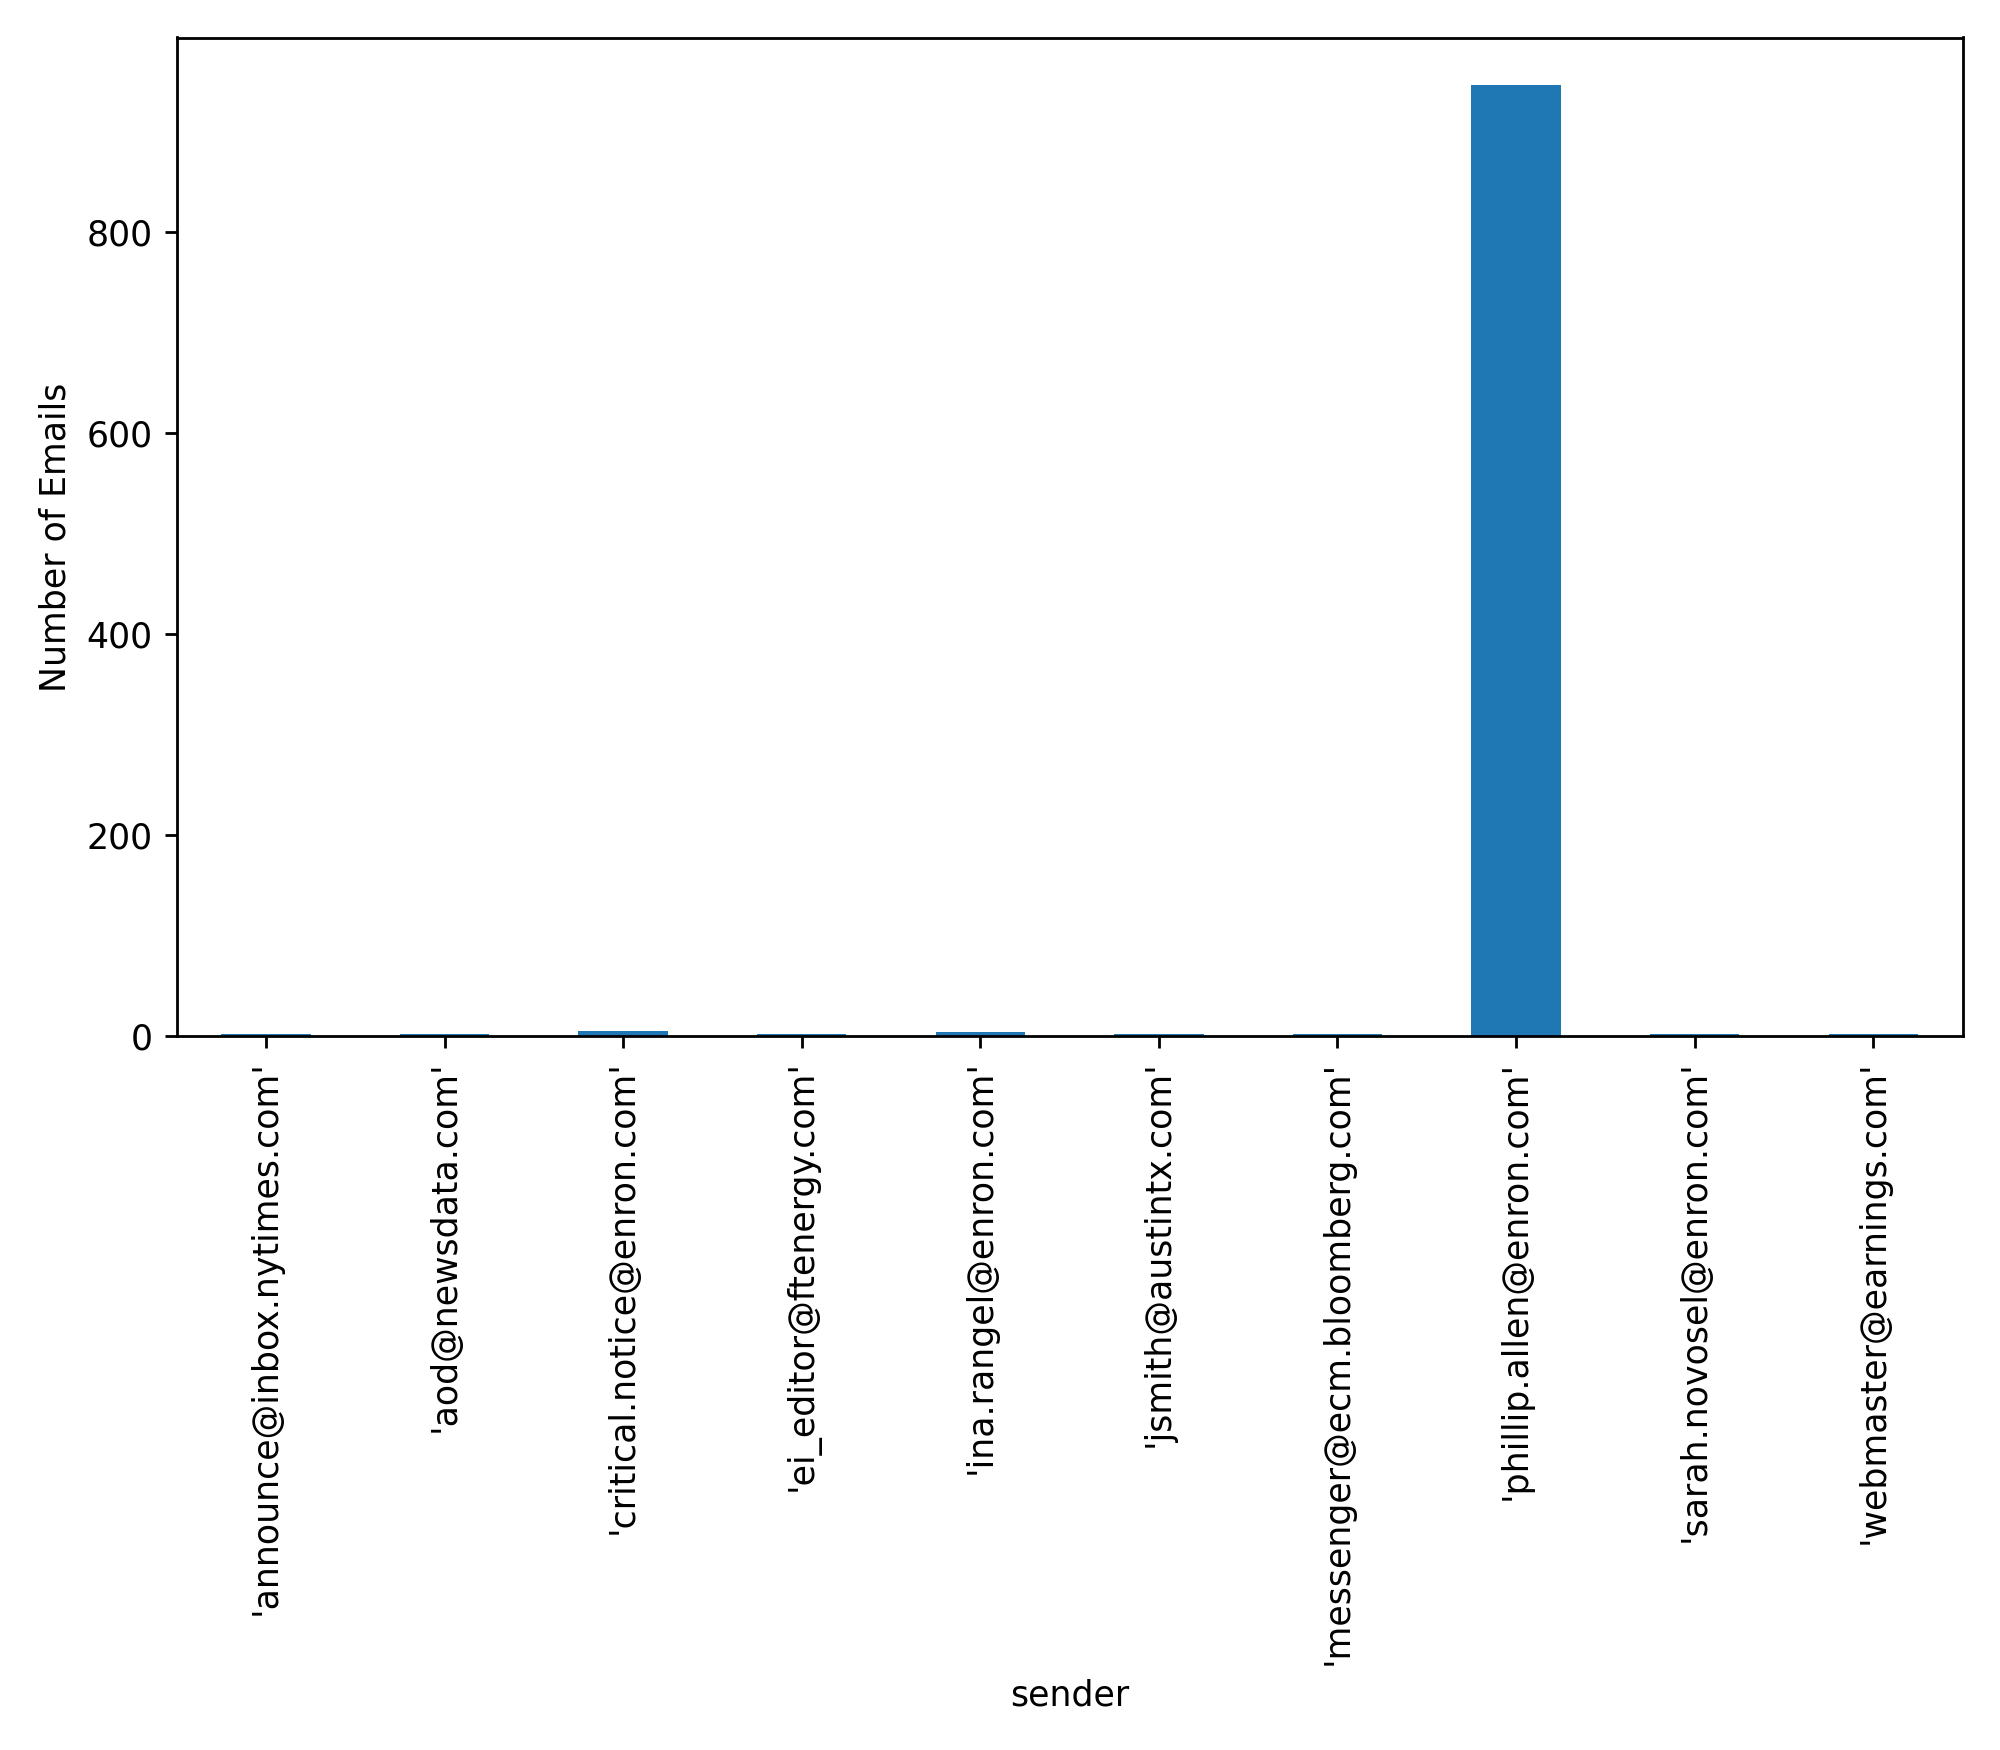

In [18]:
df_sent = df[df.groupby(['From'])['From'].transform('count') > 1]
plt.figure(1,(8,7))
df_sent['sender'] = df_sent['From'].apply(get_Email_address)
df_sent.groupby('sender')['sender'].count().plot.bar()
plt.ylabel('Number of Emails')
plt.tight_layout()

Note: since each email could be recevied by more than one person, I created a new list of recipients to see who are the most frequent email receivers.

In [19]:
recipient_list = df2['To'].apply(get_Email_address).to_list()
recipient_list_separated = []
max_receivers = 1

for i in recipient_list:
    #cnt += 1
    splitter = i.split(',')
    if len(splitter) > max_receivers:
        max_receivers = len(splitter)
        #index_keeper = cnt
    for j in splitter:
        j2 = re.sub(' ', '', j)
        recipient_list_separated.append(j2)

print('After separting the recipients, the number of receivers increased from {} to {}'.format(len(recipient_list), len(recipient_list_separated)))
print('\n max number of receivers is:', max_receivers)

After separting the recipients, the number of receivers increased from 995 to 1341

 max number of receivers is: 70


In [20]:
my_dict = {i:recipient_list_separated.count(i) for i in recipient_list_separated}

sorted_my_dict = sorted(my_dict.items(), key=operator.itemgetter(1), reverse=True)

most_recipient = sorted_my_dict[:25]

<IPython.core.display.Javascript object>


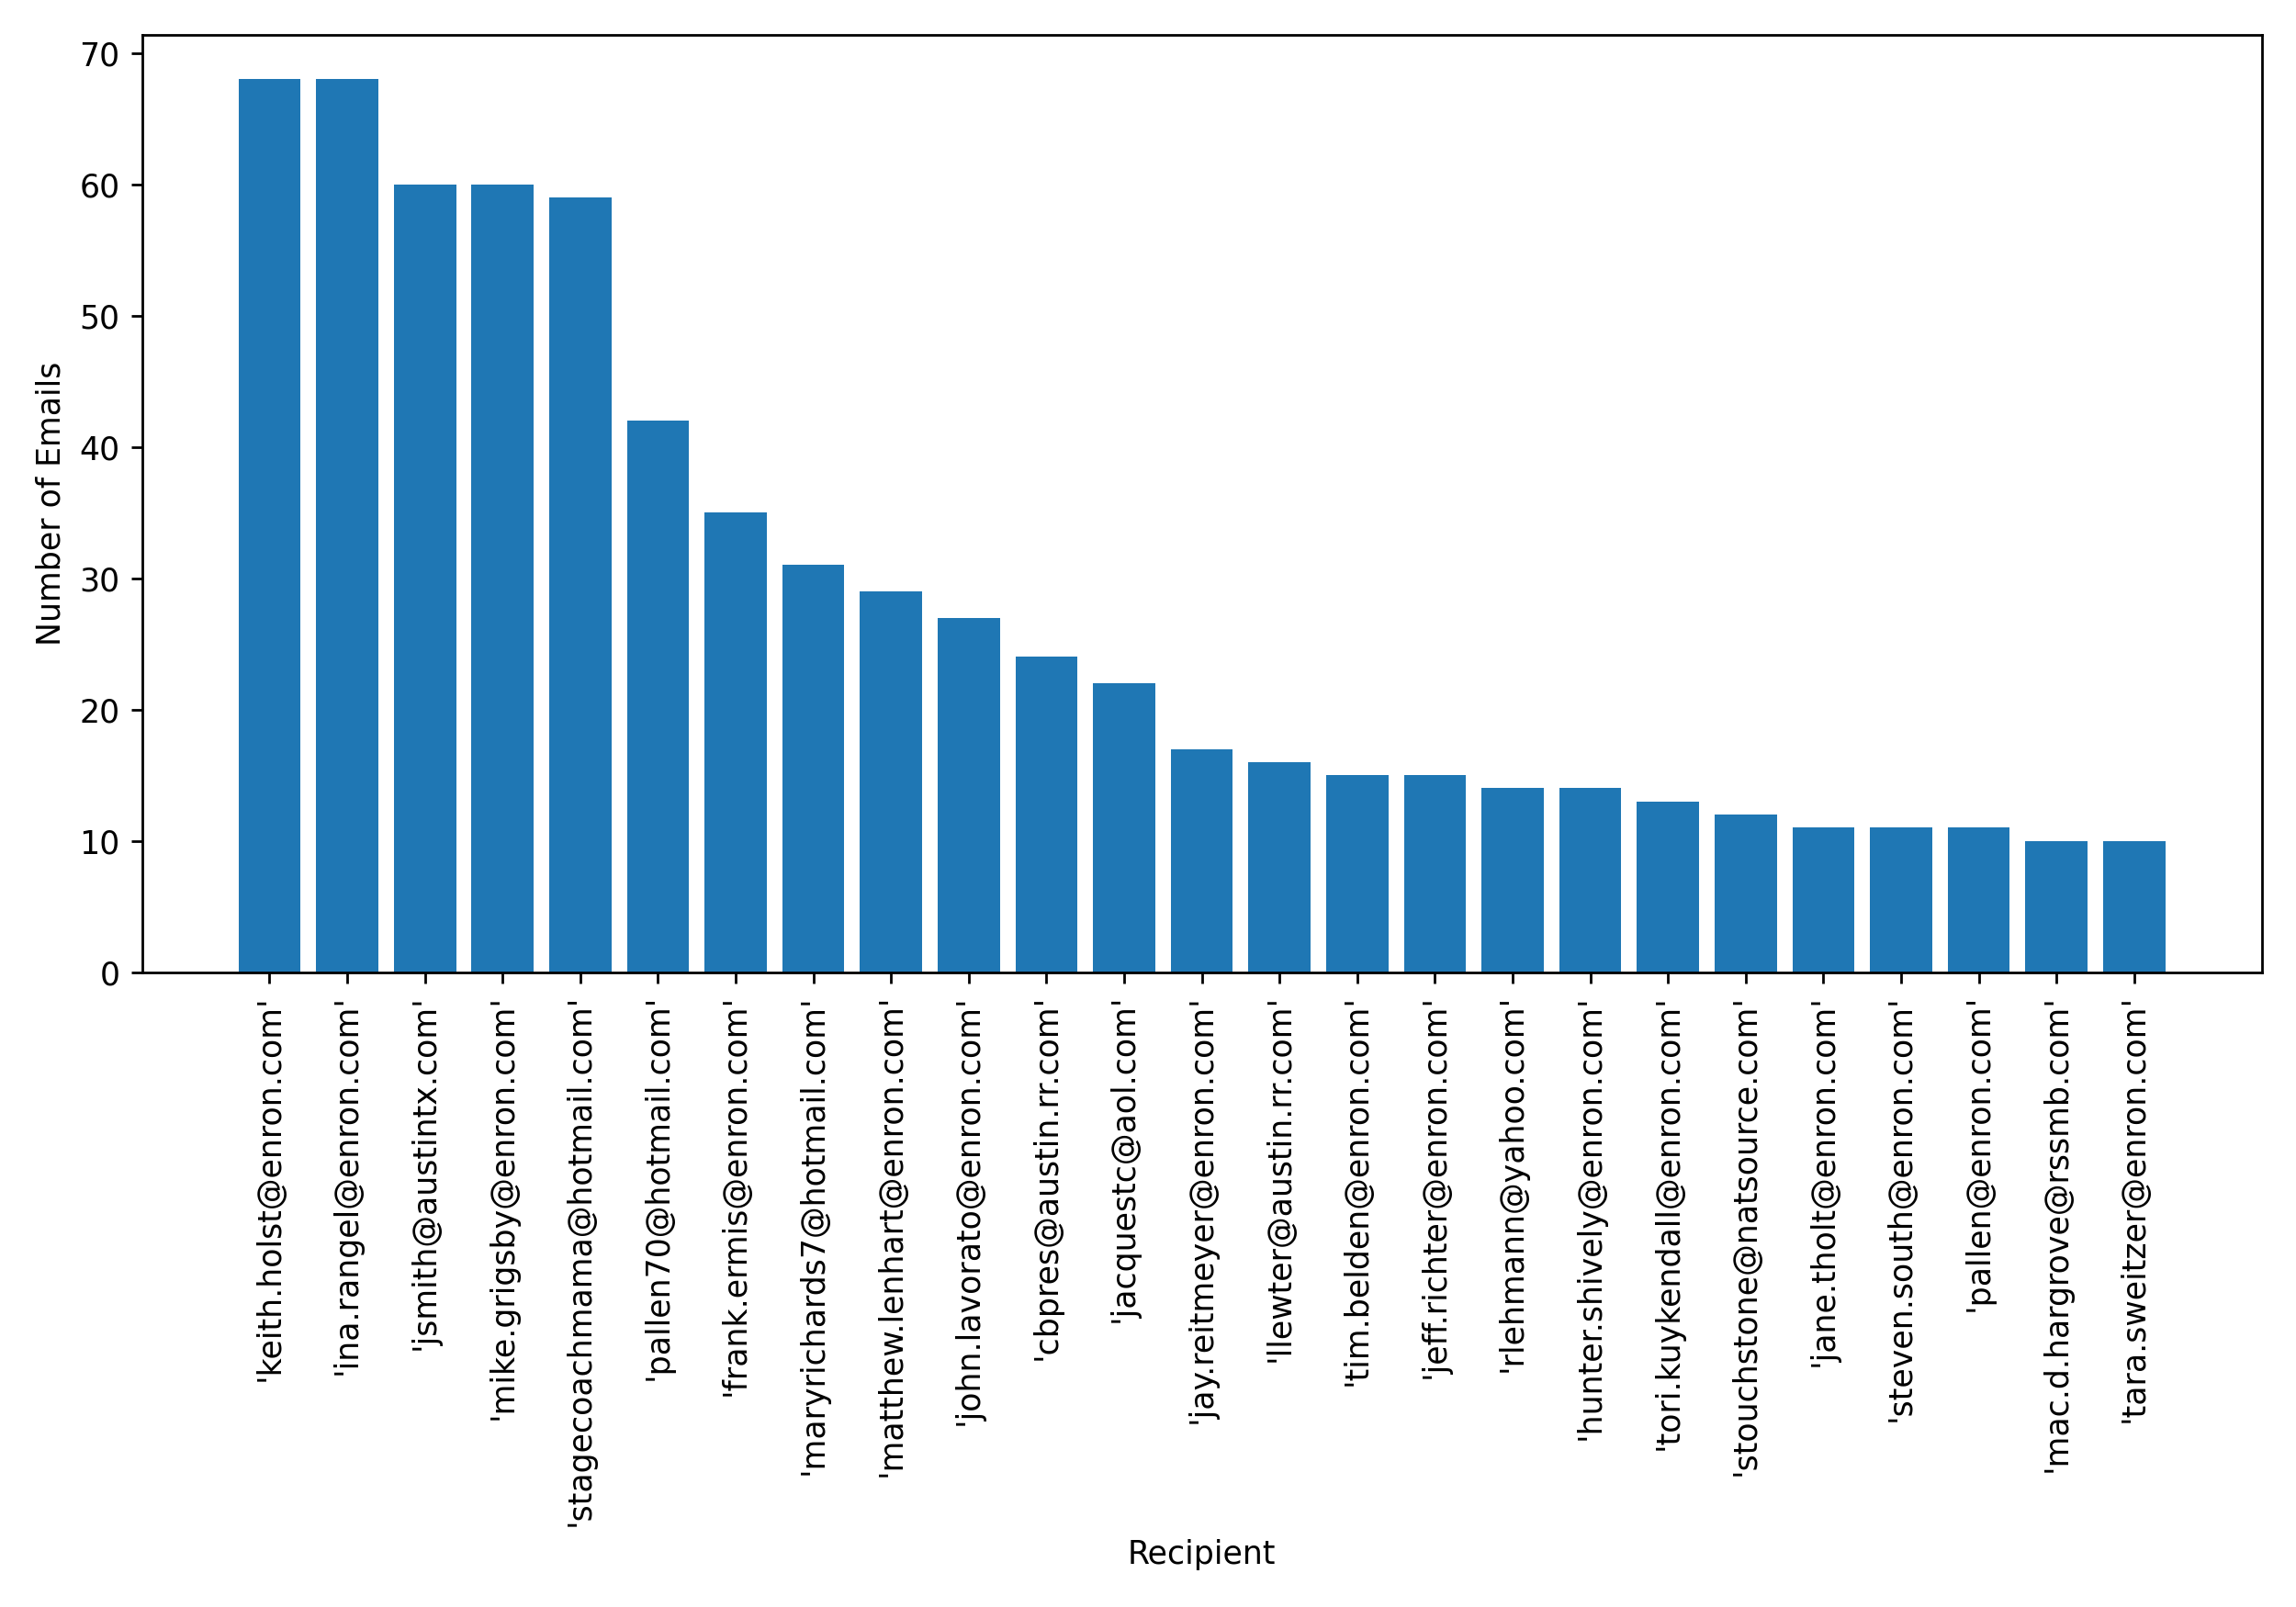

In [22]:
most_recipient_email = []
most_recipient_val = []

for k in most_recipient:
    most_recipient_email.append(k[0])
    most_recipient_val.append(k[1])

plt.figure(2,(10,7))
plt.bar(most_recipient_email, most_recipient_val)
plt.xticks(rotation = 90)
plt.ylabel('Number of Emails')
plt.xlabel('Recipient')
plt.tight_layout()

Figure 2 shows 'Keith Holst', 'Ina Rangel', 'J. Smith', and ' Mike Grigsby' are among the most frequent email receivers. I think, they might be also important people in Enron.

In [23]:
date_dict= {}
set_dates = set(list(df.dates))
for i in set_dates:
    date_dict[i]= df.dates[df.dates == i].value_counts()

In [24]:
#creating the variables for plotting
keys =date_dict.keys()
values =date_dict.values()
x=list(keys)
y=list(values)

<IPython.core.display.Javascript object>


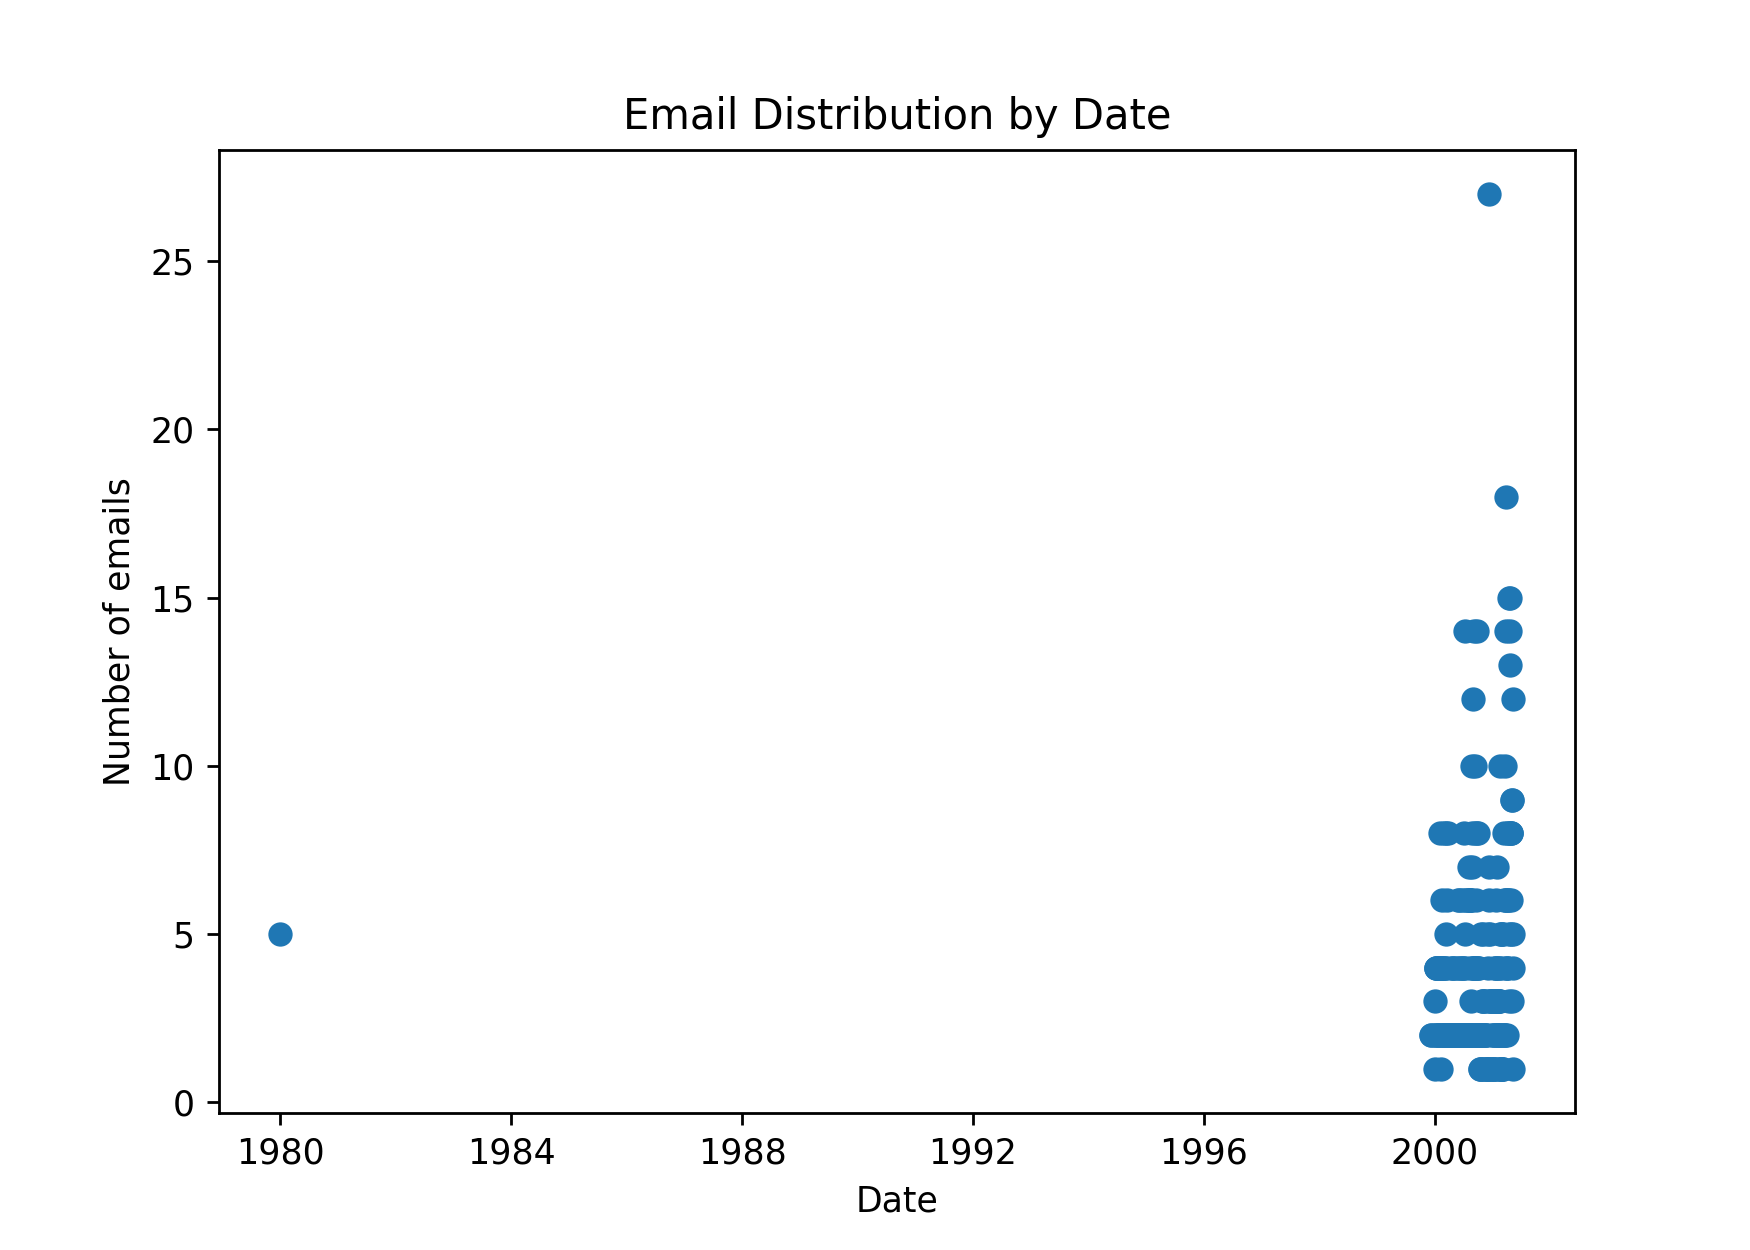

In [25]:
plt.figure(3, figsize=(7,5)) 
plt.scatter(x,y, label="Email Count")
plt.xlabel('Date') 
plt.ylabel("Number of emails") 
plt.title('Email Distribution by Date') 
plt.show()

Figure 3 shows the email distribution by date and also outlier emails.

<IPython.core.display.Javascript object>


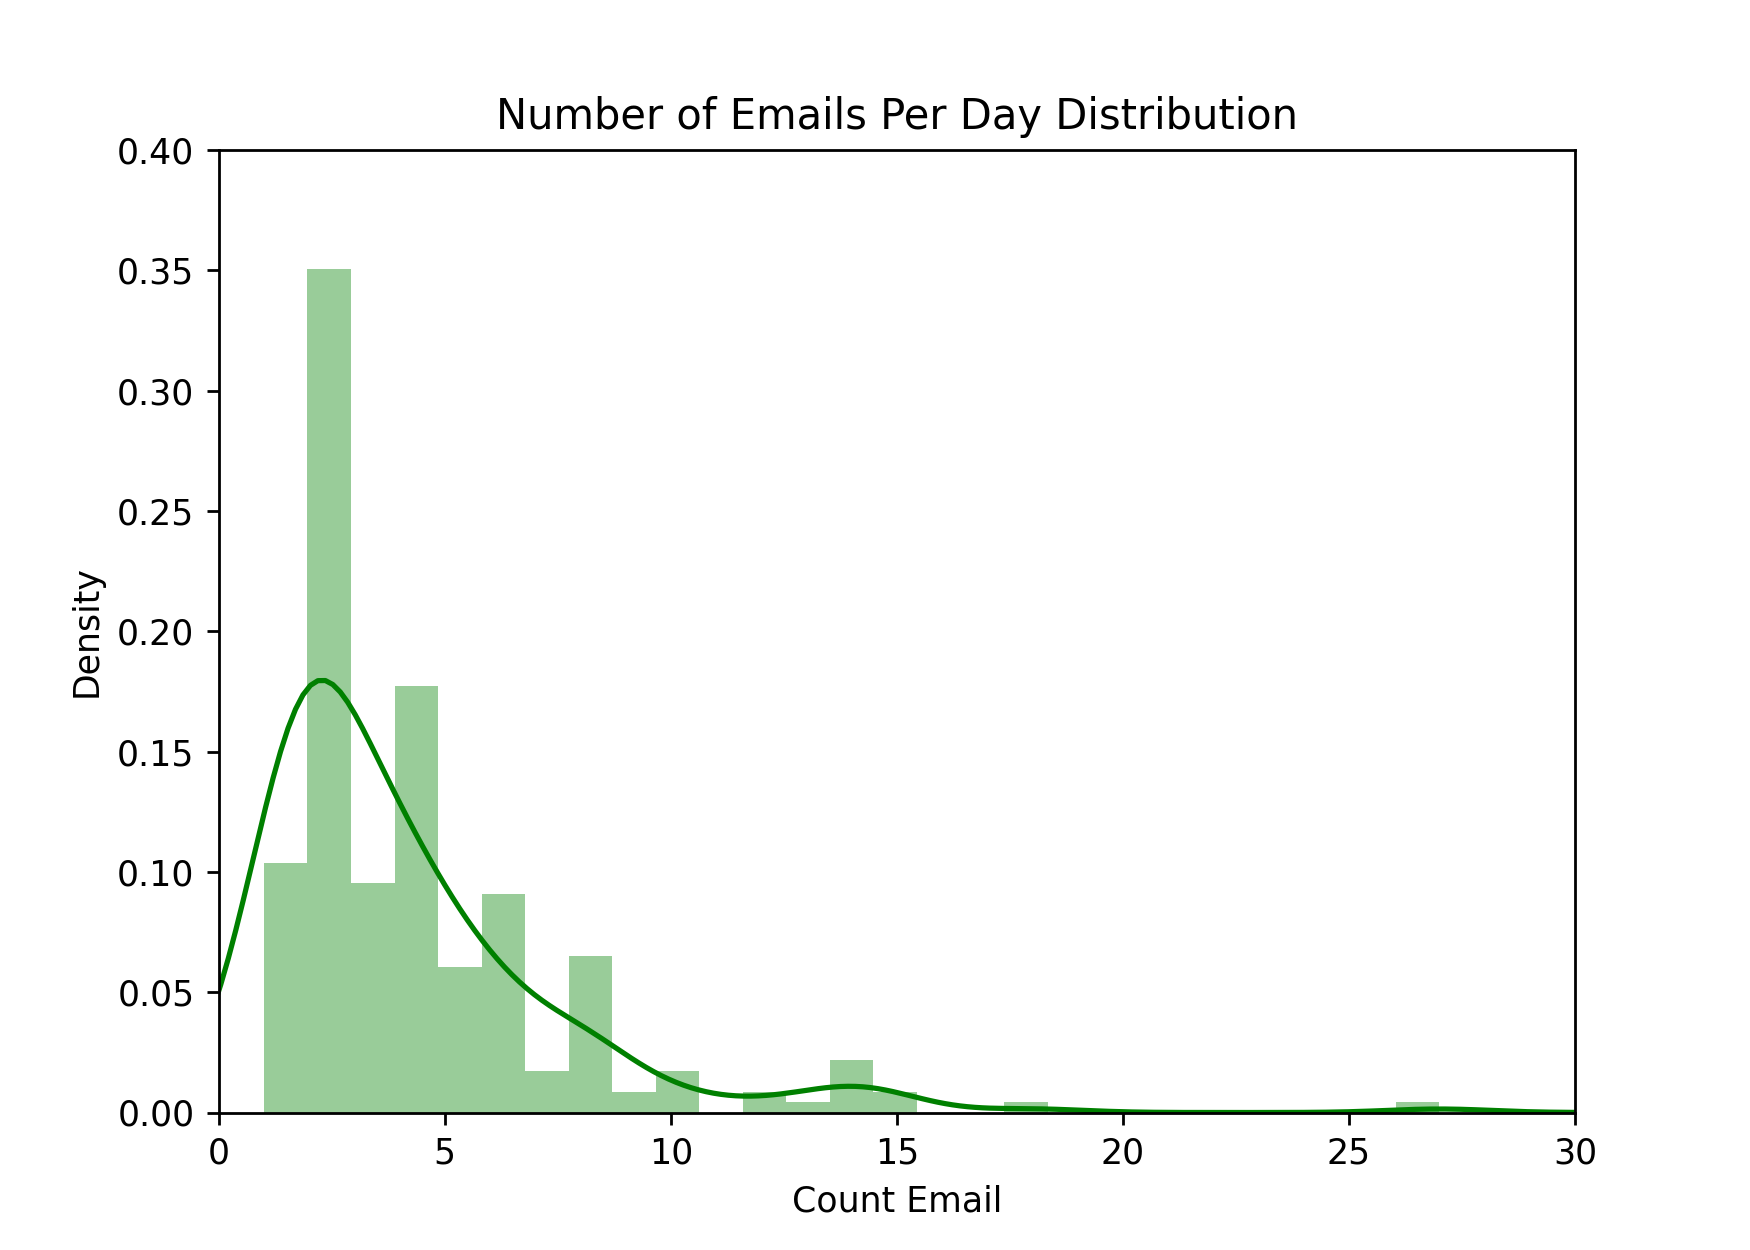

In [26]:
plt.figure(4, figsize=(7,5))
sns.distplot(y,hist=True, color = 'green').set(xlim=(0,30),ylim=(0,0.4))
plt.xlabel("Count Email")
plt.title("Number of Emails Per Day Distribution")
plt.show()

Figure 4 shows the number of emails per day distribution. I wanted to check email frequency density i.e., email exchange happened uniformly or there are some days with more email exchange.

In [27]:
df[df['dates'] == df.dates.min()]

Date  \
664  Mon, 31 Dec 1979 16:00:00 -0800 (PST)   
698  Mon, 31 Dec 1979 16:00:00 -0800 (PST)   
715  Mon, 31 Dec 1979 16:00:00 -0800 (PST)   
716  Mon, 31 Dec 1979 16:00:00 -0800 (PST)   
842  Mon, 31 Dec 1979 16:00:00 -0800 (PST)   

                                       From  \
664  frozenset({'phillip.allen@enron.com'})   
698  frozenset({'phillip.allen@enron.com'})   
715  frozenset({'phillip.allen@enron.com'})   
716  frozenset({'phillip.allen@enron.com'})   
842  frozenset({'phillip.allen@enron.com'})   

                                                    To            Subject  \
664          frozenset({'muller@thedoghousemail.com'})   Re: (No Subject)   
698  frozenset({'stephen.harrington@enron.com', 'ma...                NaN   
715                 frozenset({'jsmith@austintx.com'})  Re: MISSION SOUTH   
716  frozenset({'john.lavorato@enron.com', 'scott.n...  systems wish list   
842           frozenset({'maryrichards7@hotmail.com'})                Re:   

                                               content   new_date       dates  
664  How is your racing going?  What category are y... 1980-01-01  1980-01-01  
698  EOL report for TV in conference on 33\n\n\nCas... 1980-01-01  1980-01-01  
715  Jeff,\n\n I want to bid $2.8 for sagewood with... 1980-01-01  1980-01-01  
716  attached is the systems wish list for the gas ... 1980-01-01  1980-01-01  
842  Mary,\n\n It is OK to buy a carpet shampooer.\... 1980-01-01  1980-01-01

There are 5 outliers (email sent in 01/01/1980) that I would like to remove them for some of my analysis.

In [28]:
dff = df[df['dates'] != df.dates.min()]

In [29]:
dff.dates.min(), dff.dates.max()

(datetime.date(1999, 12, 10), datetime.date(2001, 5, 14))

<IPython.core.display.Javascript object>


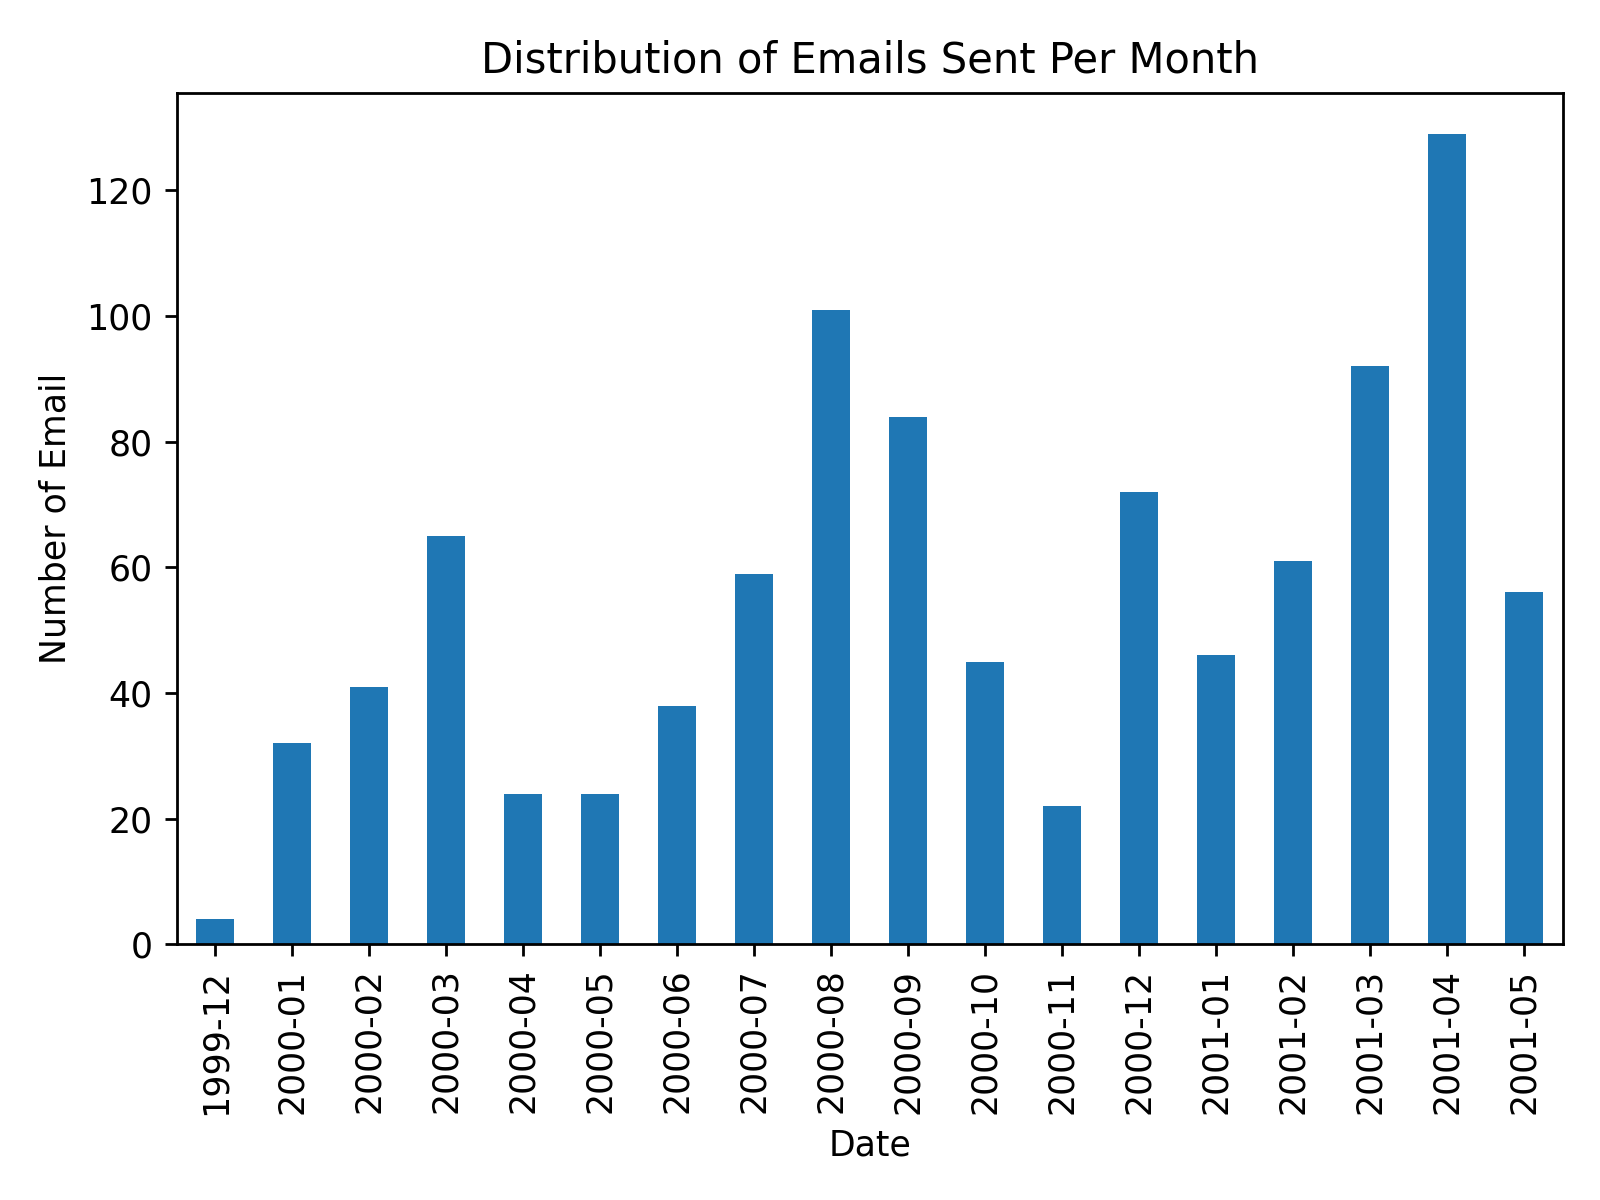

In [33]:
per_month = dff['new_date'].dt.to_period("M")
plt.figure(5)
df.groupby(per_month)['Date'].count().plot.bar()
plt.xlabel('Date')
plt.ylabel('Number of Email')
plt.title('Distribution of Emails Sent Per Month')
plt.tight_layout()

In [34]:
df_allen = df[df['From'] == "frozenset({'phillip.allen@enron.com'})"]
df_allen.head()

Date  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)   

                                     From  \
0  frozenset({'phillip.allen@enron.com'})   
1  frozenset({'phillip.allen@enron.com'})   
2  frozenset({'phillip.allen@enron.com'})   
3  frozenset({'phillip.allen@enron.com'})   
4  frozenset({'phillip.allen@enron.com'})   

                                       To    Subject  \
0     frozenset({'tim.belden@enron.com'})        NaN   
1  frozenset({'john.lavorato@enron.com'})        Re:   
2   frozenset({'leah.arsdall@enron.com'})   Re: test   
3    frozenset({'randall.gay@enron.com'})        NaN   
4     frozenset({'greg.piper@enron.com'})  Re: Hello   

                                             content            new_date  \
0                          Here is our forecast\n\n  2001-05-14 23:39:00   
1  Traveling to have a business meeting takes the... 2001-05-04 20:51:00   
2                     test successful.  way to go!!! 2000-10-18 10:00:00   
3  Randy,\n\n Can you send me a schedule of the s... 2000-10-23 13:13:00   
4                Let's shoot for Tuesday at 11:45.   2000-08-31 12:07:00   

        dates  
0  2001-05-14  
1  2001-05-04  
2  2000-10-18  
3  2000-10-23  
4  2000-08-31

Figure 5, Observation: There is a pick of emails sent in May 2001. <br>

Note: I could specify emails sent by 'Phillip Allen' here. Since ~95% of email in our dataset belongs to 'Phillip Allen', I think it would be justified to assume 'df_allen ~= df'.

<IPython.core.display.Javascript object>


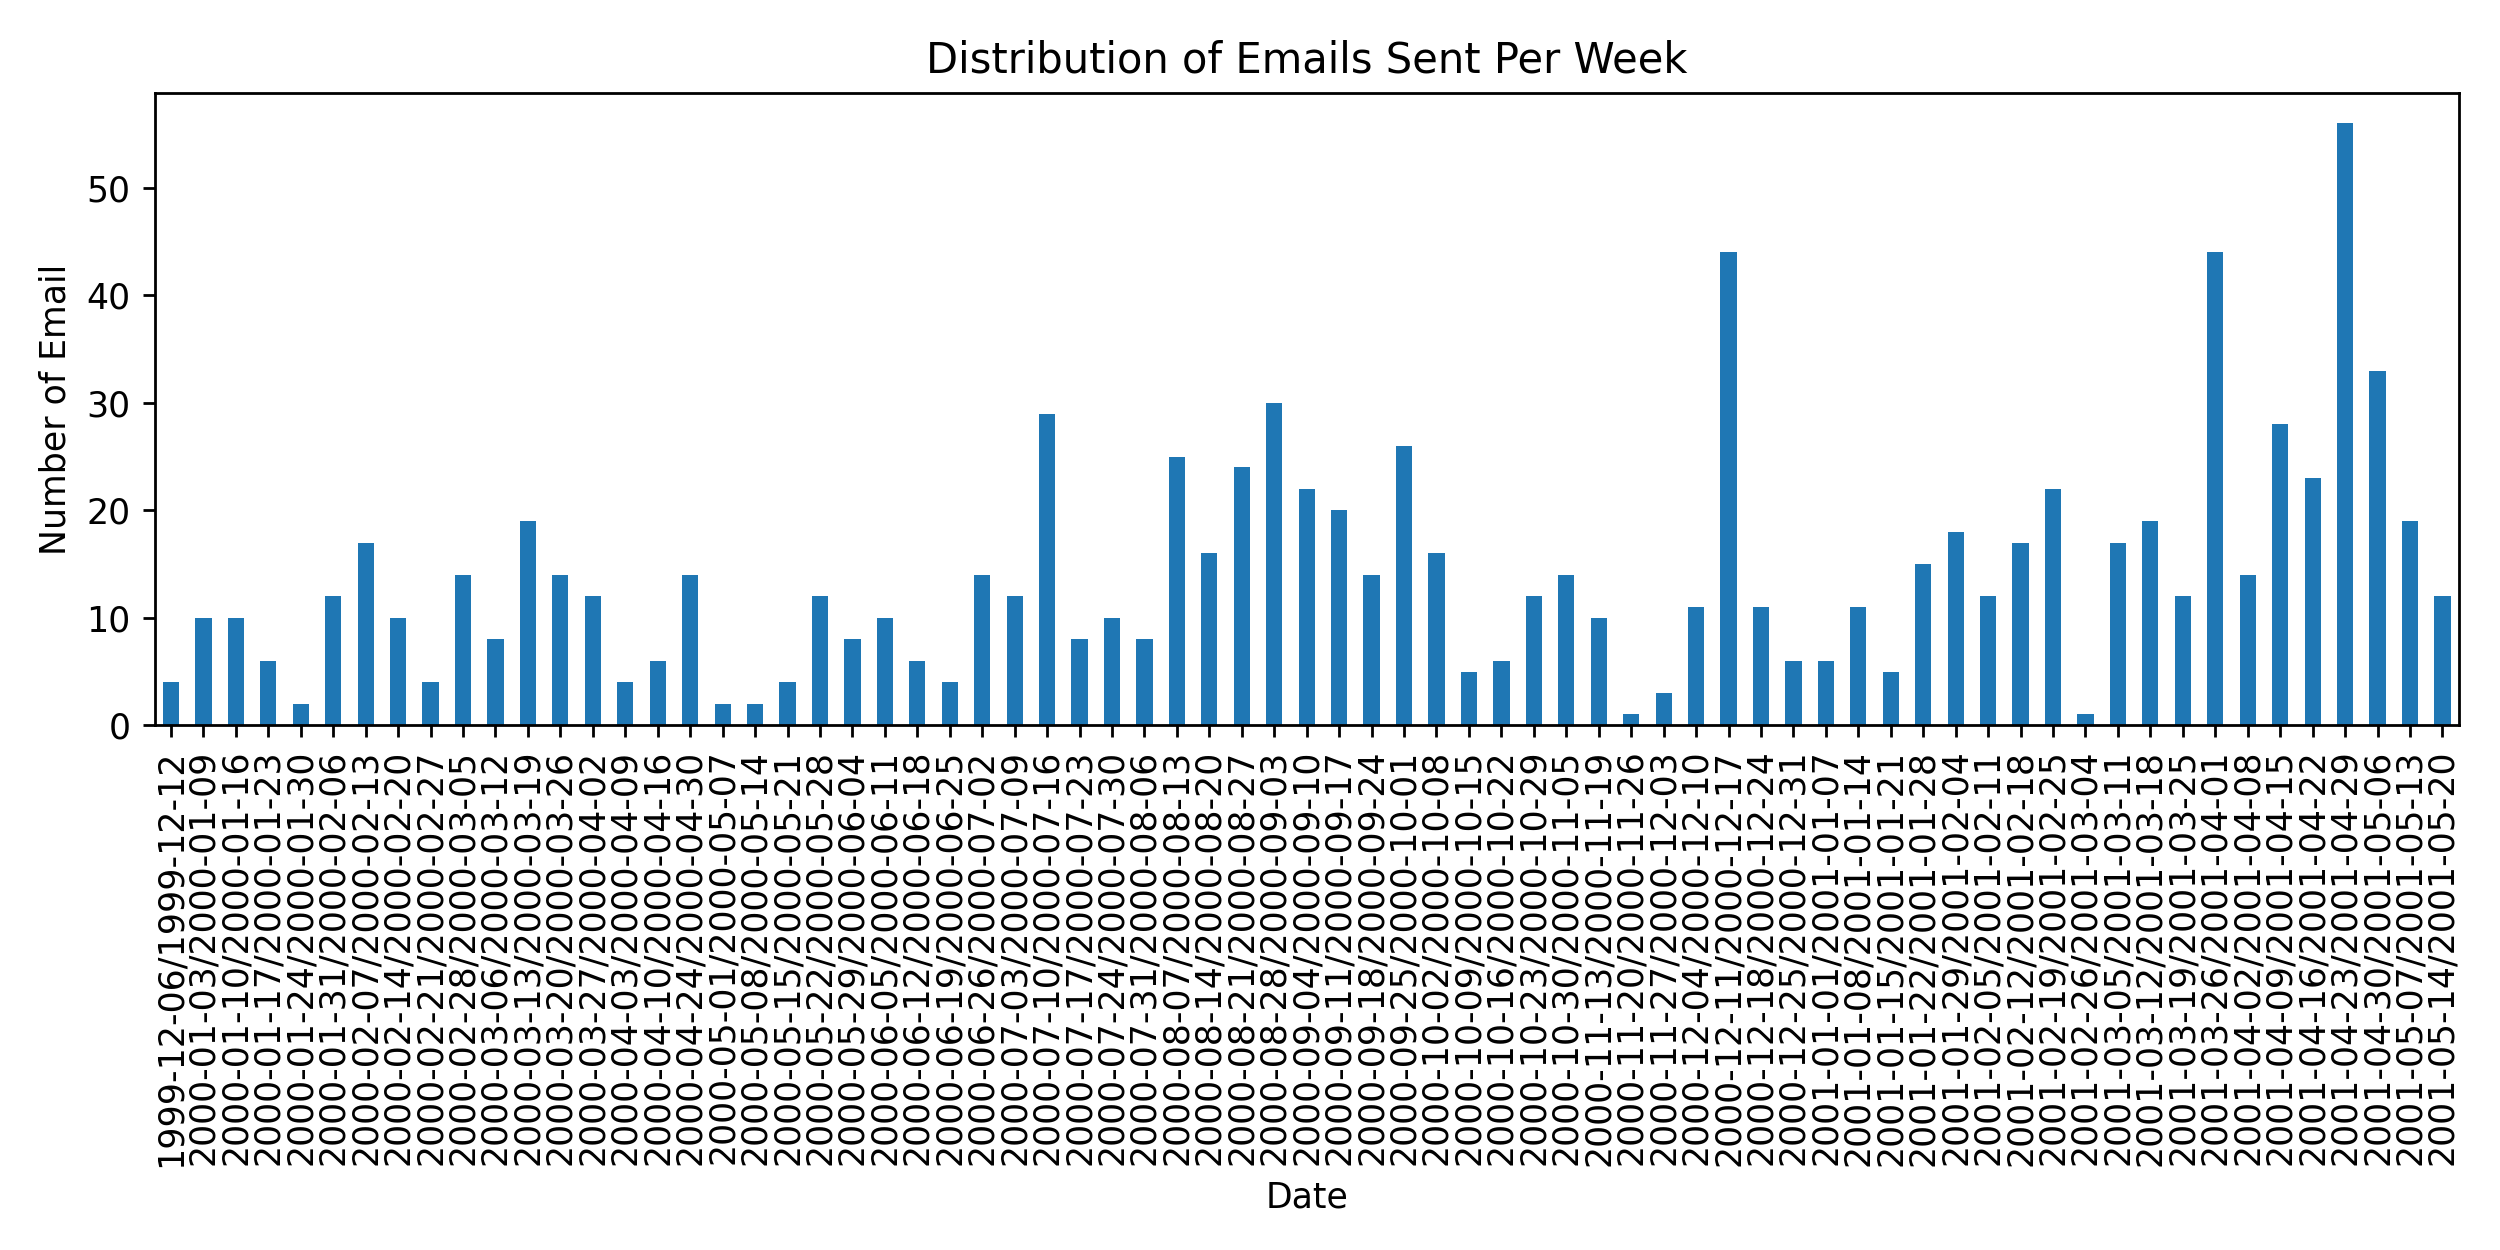

In [35]:
per_week = dff['new_date'].dt.to_period("W")
plt.figure(6,(10,5))
df.groupby(per_week)['Date'].count().plot.bar()
plt.xlabel('Date')
plt.ylabel('Number of Email')
plt.title('Distribution of Emails Sent Per Week')
plt.tight_layout()

Figure 6: We can observer the pick happend at the last week of May, 2001. Maybe, something happend during that time in Enron.

Here, I am creating a new dataframe and separating the first 3 recipients in 3 different columns.  <br>

In [36]:
#creating a new dataframe
recipients = df2['To'].apply(get_Email_address)

#separating the string of recipients into different columns in the dataframe.
recipient_df = recipients.str.split(pat = ', ',expand = True)

#separating the first 3 series
recipient = recipient_df.iloc[:,0:3]
recipient.head()

recipient.rename(columns={0: "recipient_1", 1: "recipient_2",2:"recipient_3"}, inplace = True)

recipient['recipient_1'] = recipient['recipient_1'].str.replace('\n\t','')
recipient['recipient_2'] = recipient['recipient_2'].str.replace('\n\t','')
recipient['recipient_3'] = recipient['recipient_3'].str.replace('\n\t','')

sender = df.From
dates = df.dates
Subject = df.Subject
content = df.content

result = pd.concat([sender, recipient, dates, Subject, content],axis=1, sort=False)
result.head()

From                recipient_1  \
0  frozenset({'phillip.allen@enron.com'})     'tim.belden@enron.com'   
1  frozenset({'phillip.allen@enron.com'})  'john.lavorato@enron.com'   
2  frozenset({'phillip.allen@enron.com'})   'leah.arsdall@enron.com'   
3  frozenset({'phillip.allen@enron.com'})    'randall.gay@enron.com'   
4  frozenset({'phillip.allen@enron.com'})     'greg.piper@enron.com'   

  recipient_2 recipient_3       dates    Subject  \
0        None        None  2001-05-14        NaN   
1        None        None  2001-05-04        Re:   
2        None        None  2000-10-18   Re: test   
3        None        None  2000-10-23        NaN   
4        None        None  2000-08-31  Re: Hello   

                                             content  
0                          Here is our forecast\n\n   
1  Traveling to have a business meeting takes the...  
2                     test successful.  way to go!!!  
3  Randy,\n\n Can you send me a schedule of the s...  
4                Let's shoot for Tuesday at 11:45.

In [37]:
#creating the graph object
G = nx.from_pandas_edgelist(result, source ='From', target ='recipient_1', 
                            edge_attr=['Subject', 'dates'])

In [38]:
top_edges = sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1))
#top_edges = top_edges[:100]
len(top_edges)

256

In [39]:
#G2 = nx.from_edgelist(top_edges, create_using=G)

<IPython.core.display.Javascript object>


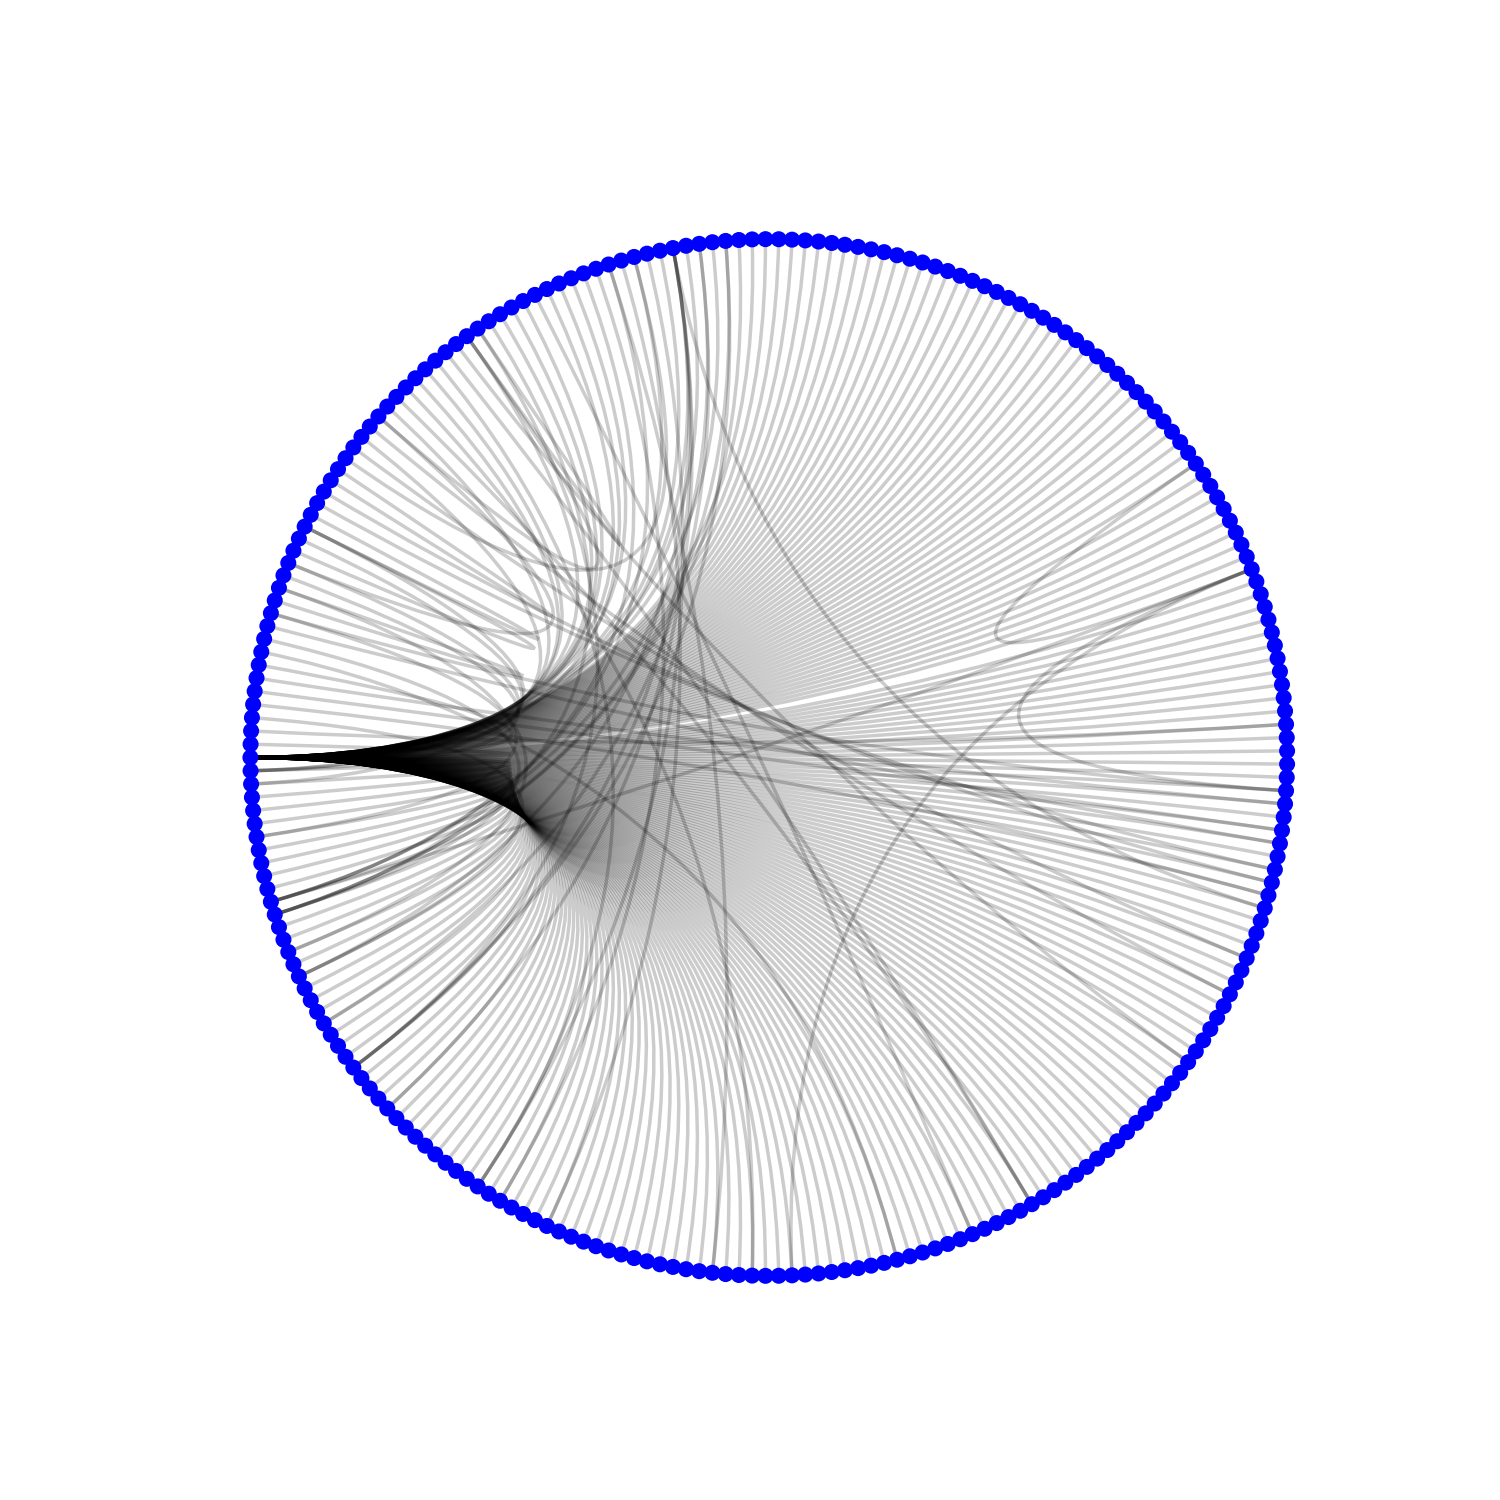

In [40]:
new_plot = nv.CircosPlot(G)
new_plot.draw()
plt.show()

Figure 7 demonstrates a graphical representation, i.e. Circos Plot, of email exchange network. I think we can recognize 'Phillip Allen, as a hub in the network.

(Circos Plot: Visualization in which nodes are ordered around the circumference of a circle and the edges are drawn within the circle, giving a clear, unclustered view of the network.)

<IPython.core.display.Javascript object>


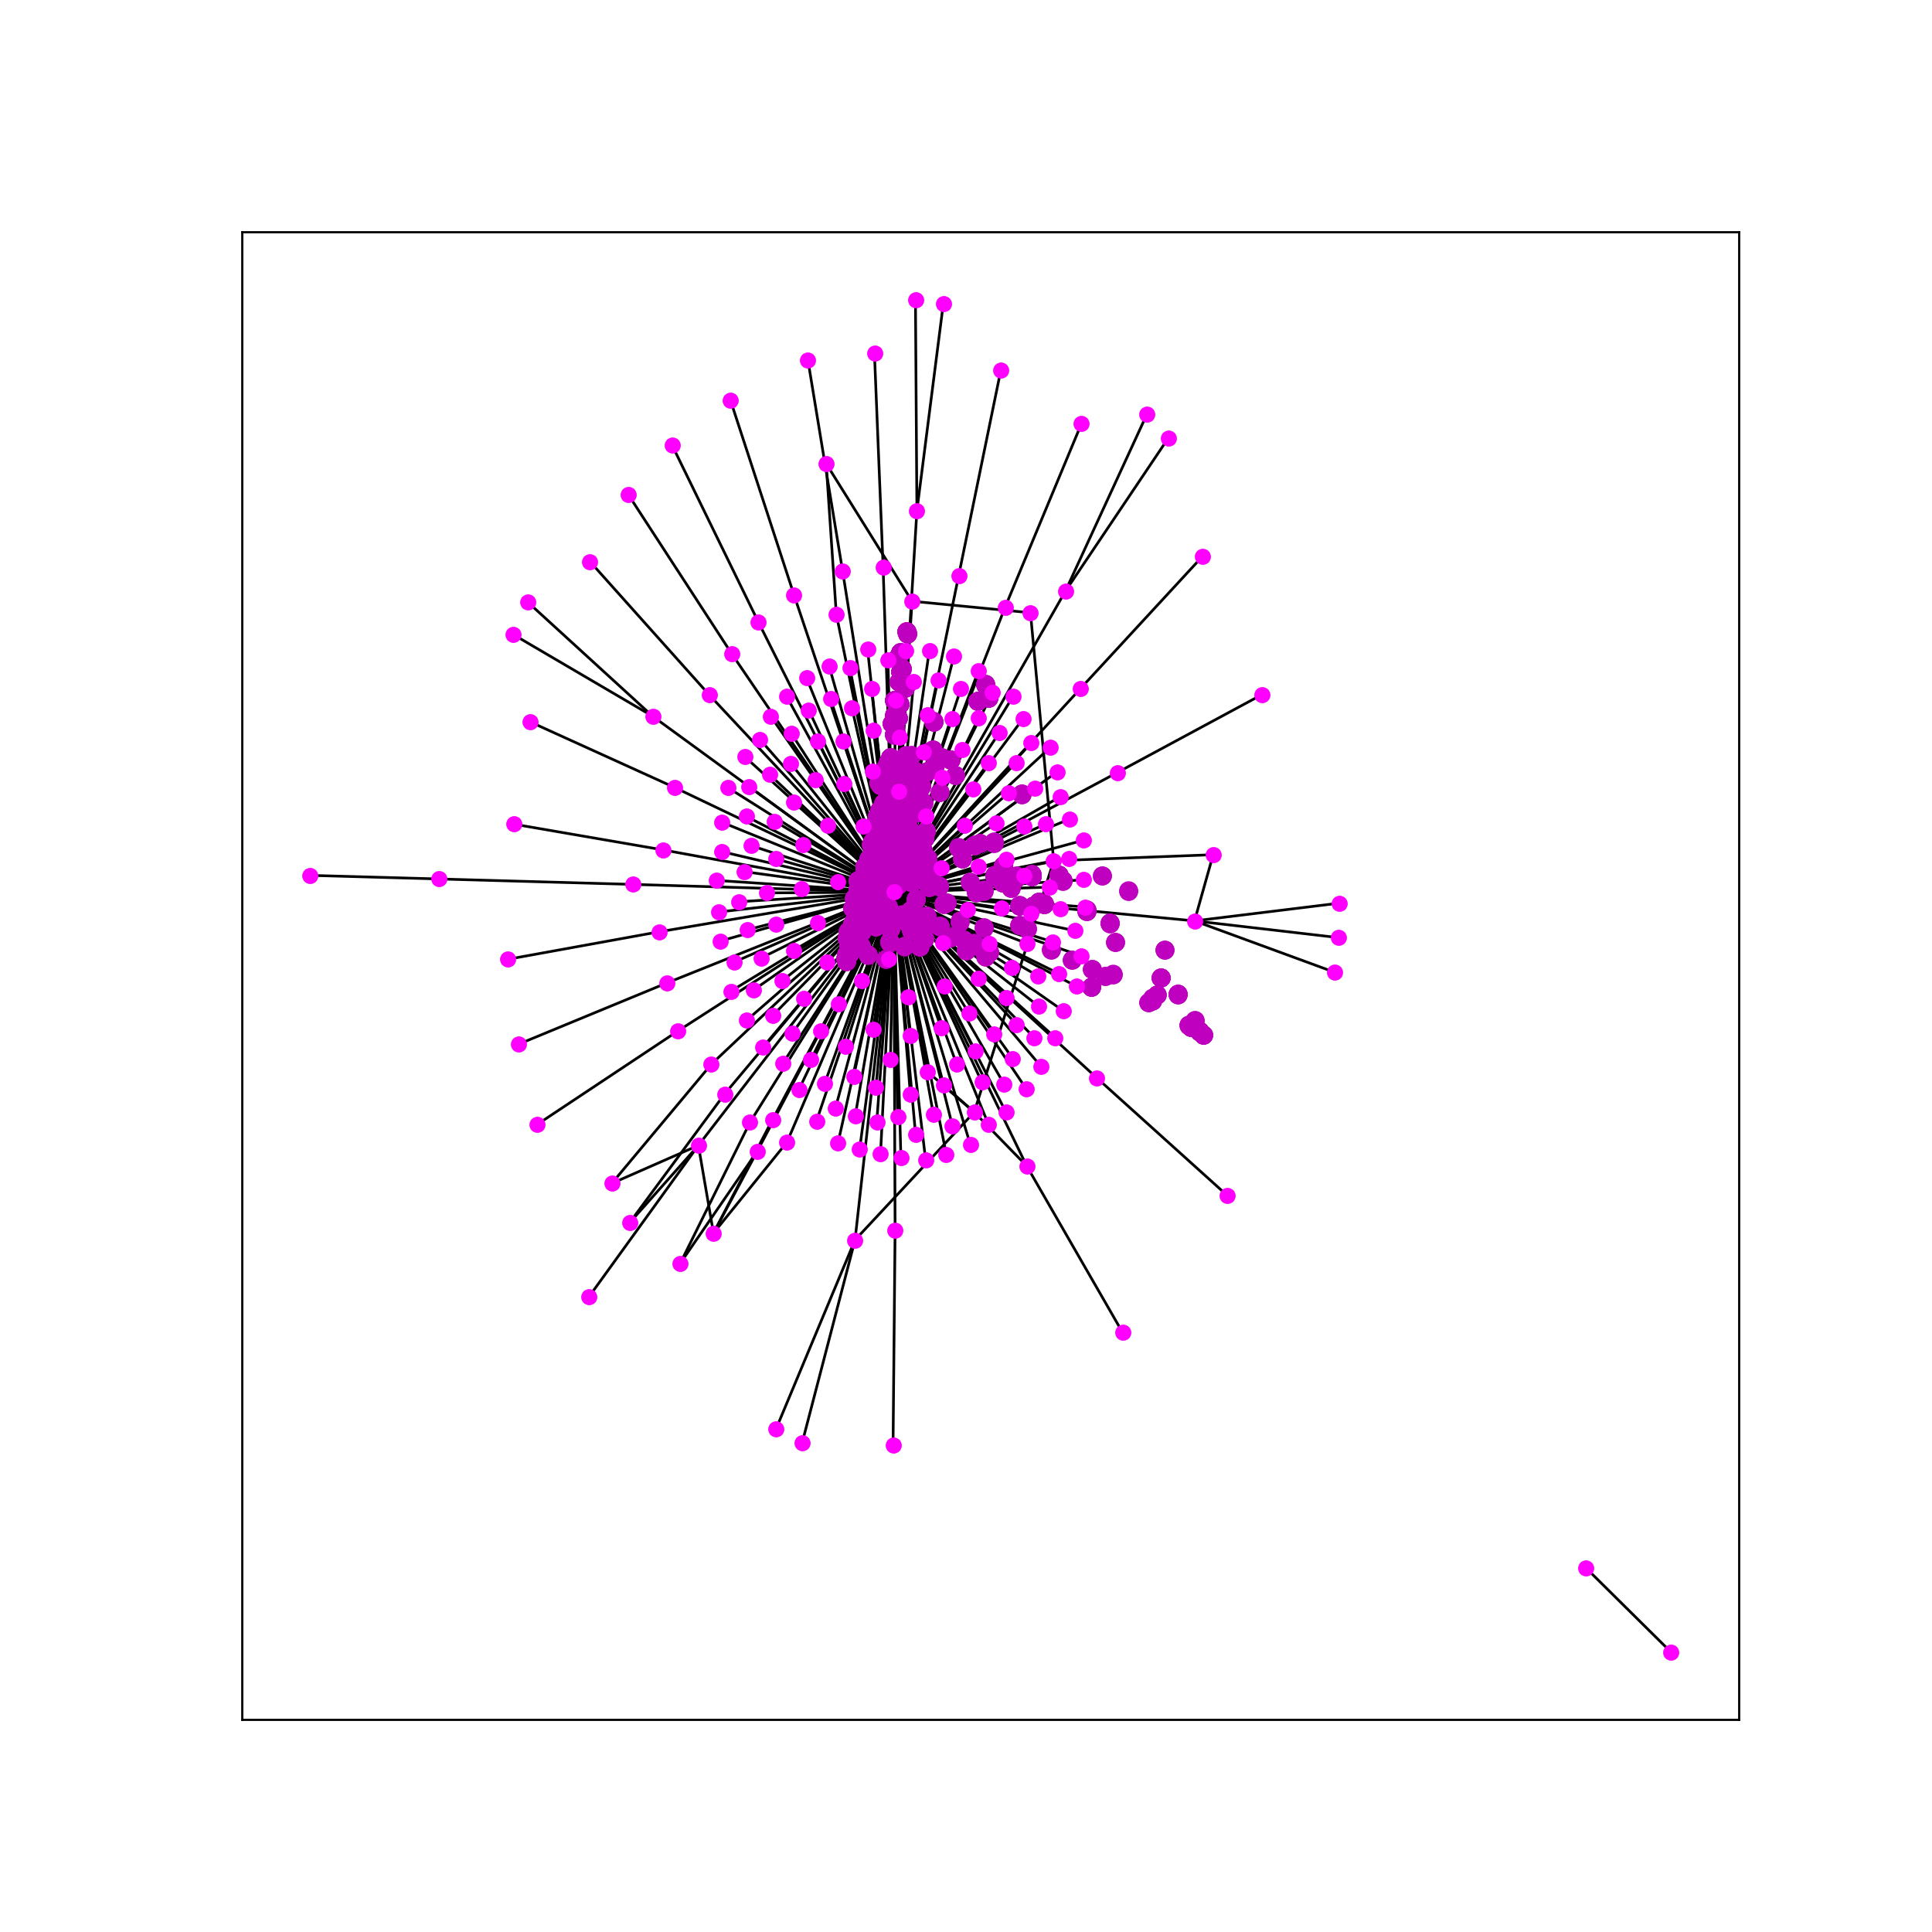

In [93]:
plt.figure(figsize=(10,10))
position = nx.spring_layout(G, k=.1,scale=2)
nx.draw_networkx(G, position, node_size=25, node_color='magenta', with_labels=False, edge_color='black')
plt.show()

Figure 8 demonstrates another graphical representation, i.e. Network Map, of email exchange network. It is obvious 'Phillip Allen' is the center of the network.

(Network Map: Visualization that positions each node using Fruchterman-Reingold force-directed algorithm.)

In [43]:
central_nodes_G = nx.algorithms.centrality.degree_centrality(G)
#central_nodes_G

# Use Case 1:
## Analyzing Topics in the Enron Email Dataset 

> I think exploring the key topics discussed in these emails would be insightful. <br>
> It would be interesting to find out what the most common topics or themes in the Enron email dataset are.

### NLP Preprocessing Task

In order to make the text ready for any NLP task, we need to perform a few preprocessing steps including:
> Removing Stop Words <br>
> Making Bigrams, Trigrams <br>
> Lemmatization <br>
> Creating a Dictionary and Corpus

In [55]:
# prep NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'com', 'use', 'ect'])

In [56]:
print(df.iloc[12]['content']) 

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/09/2000 
02:16 PM ---------------------------


Richard Burchfield
10/06/2000 06:59 AM
To: Phillip K Allen/HOU/ECT@ECT
cc: Beth Perlman/HOU/ECT@ECT 
Subject: Consolidated positions: Issues & To Do list

Phillip,
 Below is the issues & to do list as we go forward with documenting the 
requirements for consolidated physical/financial positions and transport 
trade capture. What we need to focus on is the first bullet in Allan's list; 
the need for a single set of requirements. Although the meeting with Keith, 
on Wednesday,  was informative the solution of creating a infinitely dynamic 
consolidated position screen, will be extremely difficult and time 
consuming.  Throughout the meeting on Wednesday, Keith alluded to the 
inability to get consensus amongst the traders on the presentation of the 
consolidated position, so the solution was to make it so that a trader can 
arrange the position screen to their liking (much li

In [57]:
# Convert email body to list
data = df.content.values.tolist()

In [58]:
# tokenize - break down each sentence into a list of words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  

In [59]:
data_words = list(sent_to_words(data))

In [60]:
print(data_words[2])

['test', 'successful', 'way', 'to', 'go']


In [61]:
# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)

In [62]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [63]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[200]]])

['forwarded', 'by', 'phillip', 'allen', 'hou', 'ect', 'on', 'pm', 'from', 'julie_gomez', 'am', 'to', 'hunter_shively', 'hou', 'ect', 'ect', 'phillip', 'allen', 'hou', 'ect', 'ect', 'cc', 'subject', 'alliance', 'netback', 'worksheet', 'hello', 'men', 'have', 'attached', 'my', 'worksheet', 'in', 'case', 'you', 'want', 'to', 'review', 'the', 'data', 'while', 'am', 'on', 'holiday', 'thanks', 'julie']


In [64]:
# remove stop_words, make bigrams and lemmatize
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [65]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [66]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [67]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

In [68]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [69]:
print(data_lemmatized[200])

['man', 'attach', 'want', 'datum', 'holiday', 'thank']


In [70]:
data_flatten = (list(np.concatenate(data_lemmatized).flat))

<IPython.core.display.Javascript object>


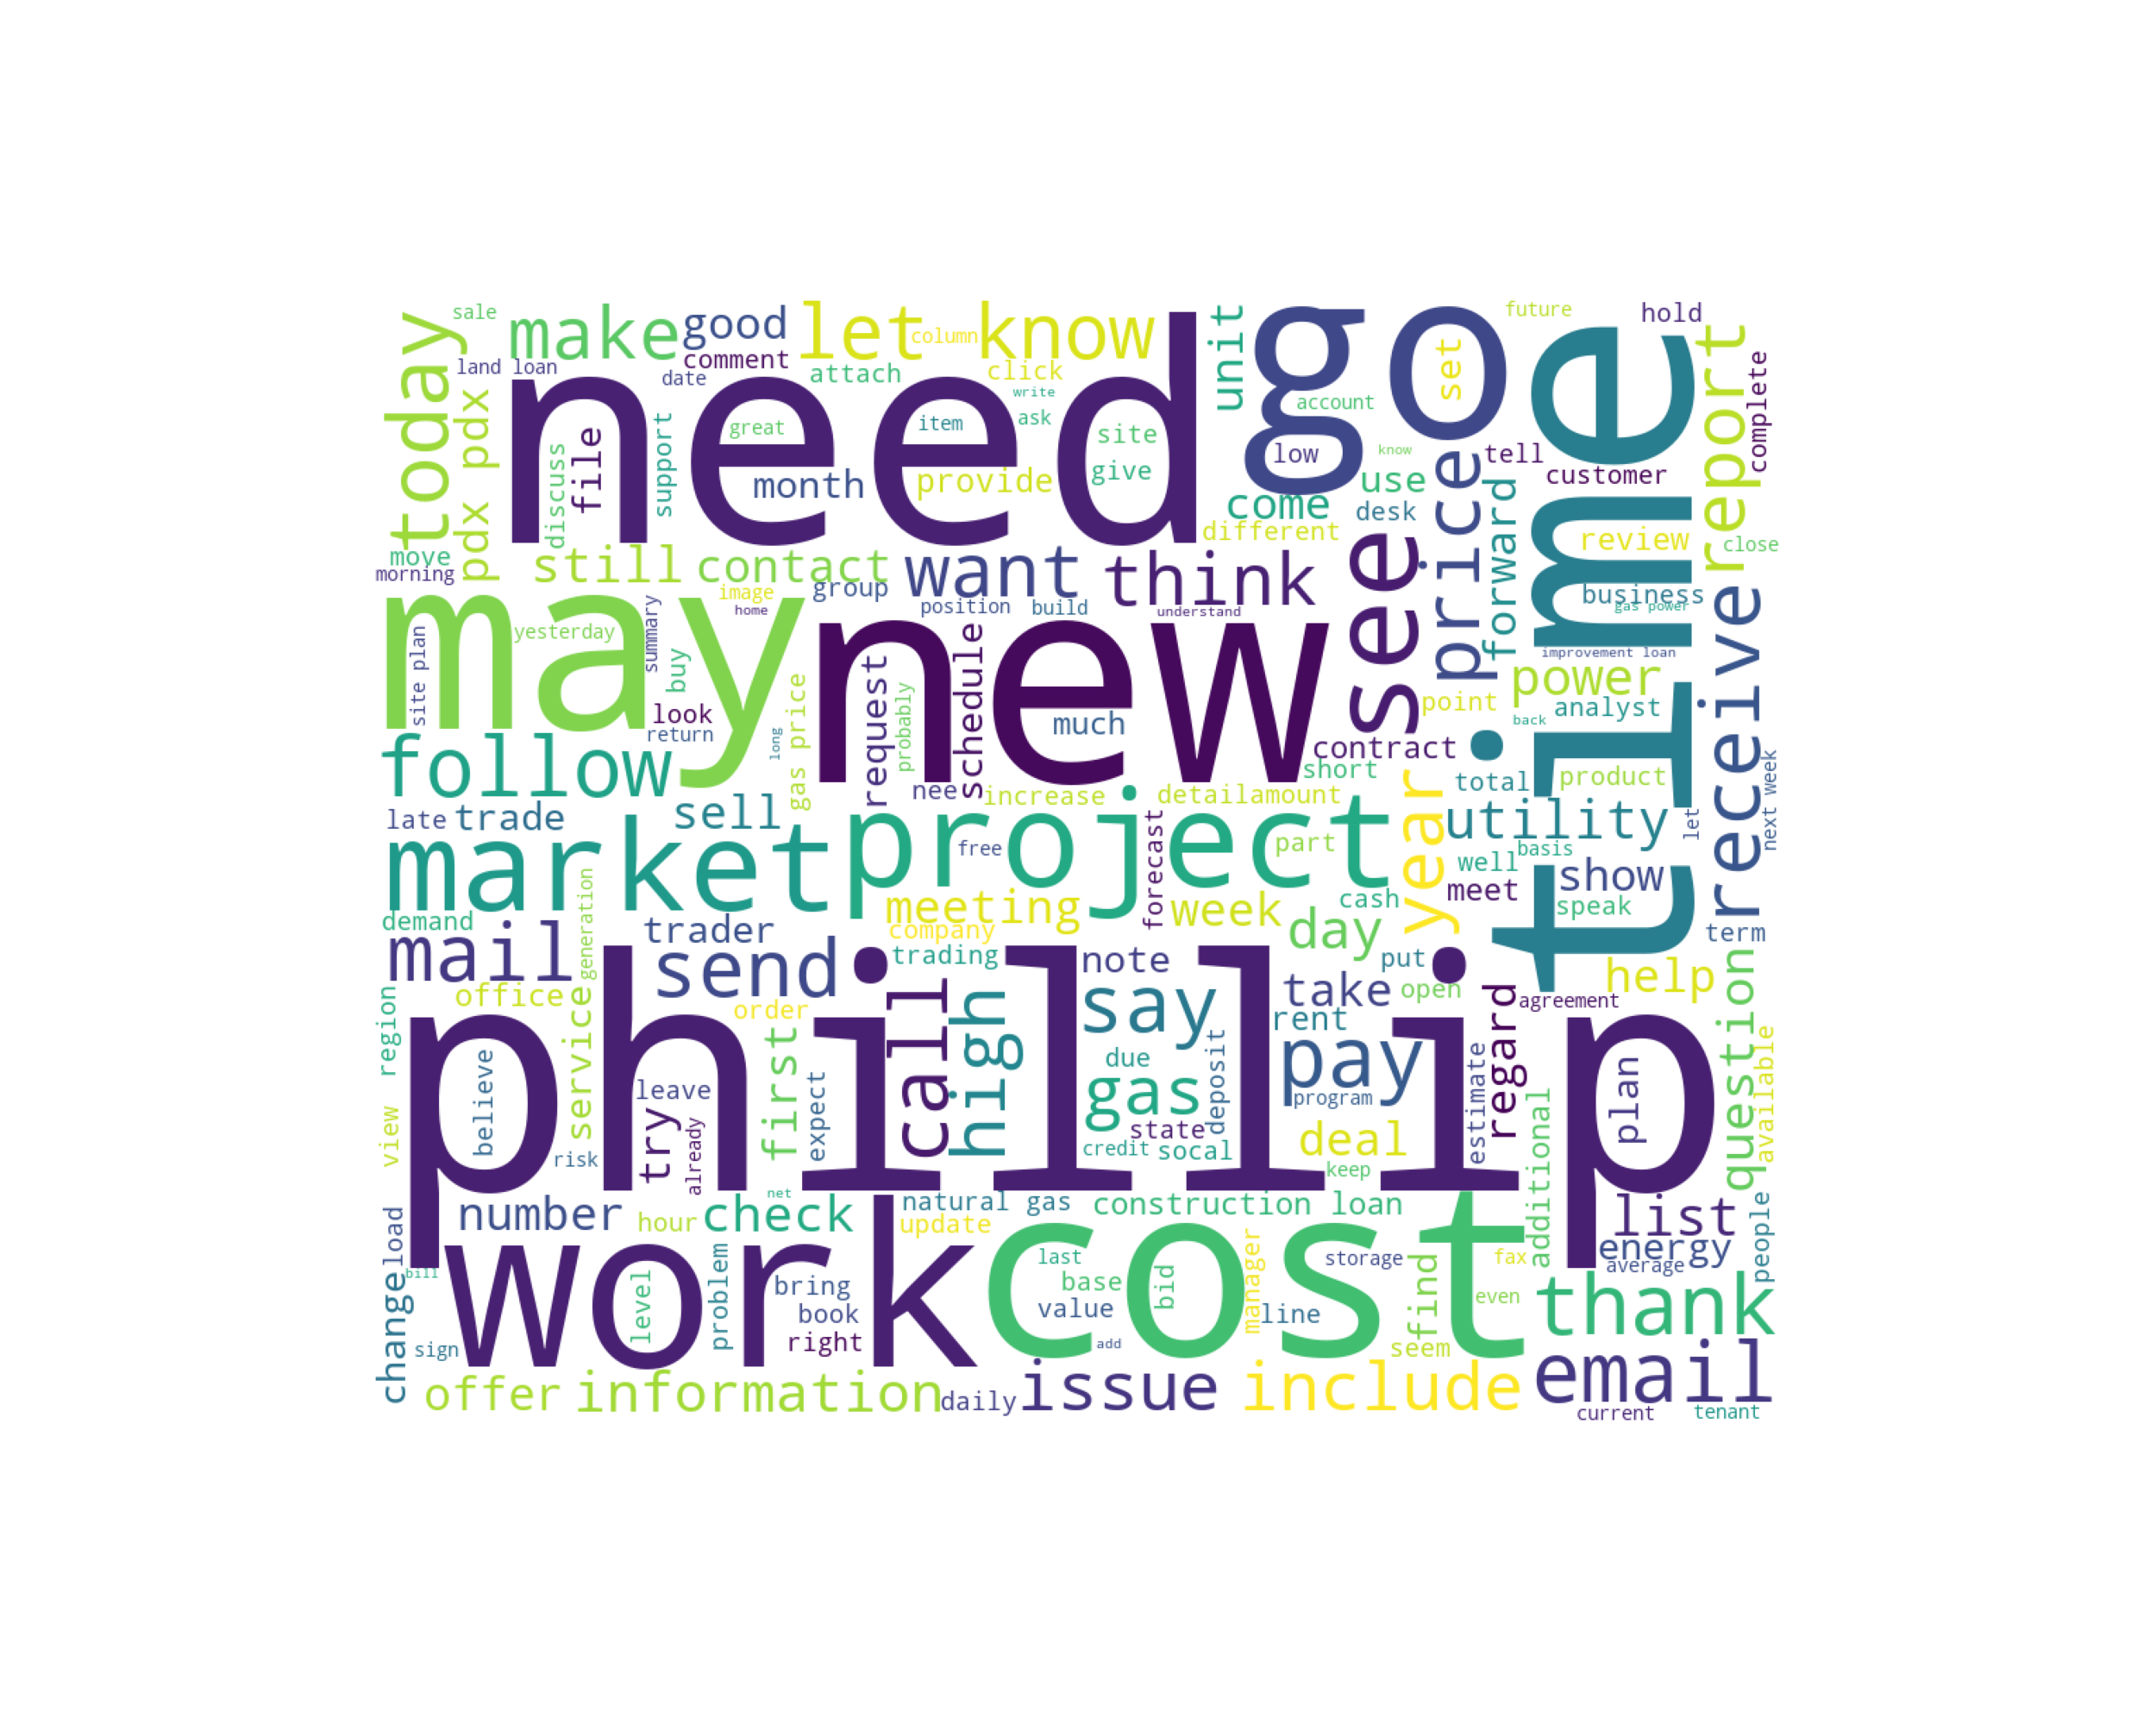

In [71]:
import wordcloud #install wordcloud and import all package necessary for wordcloud
from scipy.misc import imread 
import random
from wordcloud import WordCloud
#create a single string from list
send_list=' '.join(data_flatten)
wordcloud=WordCloud(width=1000, height =800, background_color="white", min_font_size=5, random_state=42).generate(send_list)
plt.figure(figsize=(10,8), facecolor = None )
plt.imshow(wordcloud) 
plt.axis("off")
plt.tight_layout(pad=10)
plt.show()

Figure 9 is a 'wordcloud' demonstration of the most commonly mentioned topics/words/phrases in the entire email contents.

We observe words such as 'Phillip', 'need', 'time', 'work', 'cost', 'market' are among the most popular words in the corpus.  

## Performing LDA for the Topic Modeling Task.

Latent Dirichlet Allocation (LDA) is one of the common tools for topic modeling. LDA is a bag-of-words algorithm that helps us to automatically discover topics that are contained within a set of documents.

In [72]:
# create dictionary and corpus both are needed for (LDA) topic modeling

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [84]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=18,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [85]:
print(lda_model.print_topics())# The weights reflect how important a keyword is to that topic.

[(0, '0.037*"file" + 0.036*"check" + 0.026*"get" + 0.023*"date" + 0.020*"attach" + 0.020*"list" + 0.020*"see" + 0.020*"email" + 0.018*"detail" + 0.017*"need"'), (1, '0.113*"http_www" + 0.063*"pay" + 0.047*"notice" + 0.036*"stay" + 0.033*"tenant" + 0.033*"go" + 0.030*"apartment" + 0.030*"language" + 0.029*"end" + 0.023*"seem"'), (2, '0.090*"study" + 0.014*"roughly" + 0.010*"room" + 0.000*"american" + 0.000*"subscribe" + 0.000*"reliability" + 0.000*"transportation" + 0.000*"prospectus" + 0.000*"pira" + 0.000*"north"'), (3, '0.055*"week" + 0.041*"new" + 0.031*"last" + 0.031*"phillip" + 0.026*"property" + 0.025*"back" + 0.024*"know" + 0.023*"look" + 0.021*"datum" + 0.020*"long"'), (4, '0.179*"forecast" + 0.000*"weather" + 0.000*"temperature" + 0.000*"decline" + 0.000*"increase" + 0.000*"degree" + 0.000*"spot" + 0.000*"cold" + 0.000*"winter" + 0.000*"zone"'), (5, '0.091*"response" + 0.068*"meeting" + 0.055*"storage" + 0.054*"region" + 0.050*"start" + 0.047*"pm" + 0.039*"gas" + 0.029*"forwar

In [86]:
doc_lda = lda_model[corpus]

In [87]:
# Model perplexity and topic coherence provide a convenient
# measure to judge how good a given topic model is.
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -10.620742549613652


In [88]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41233196152430773


In [89]:
# Visualize the topics
pyLDAvis.enable_notebook(sort=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [90]:
pyLDAvis.display(vis)

<b> A few observations: </b>
1. The size of the bubbles tells us how dominant a topic is across all the documents (our corpus).
2. The words on the right are the keywords driving that topic.
3. The closer the bubbles the more similar the topic. The farther they are apart the less similar.

Preferably, we want non-overlapping bubbles as much as possible spread across the chart.

### Determining the Optimal Number of Topics

In [80]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics.

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [81]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=1)

<IPython.core.display.Javascript object>


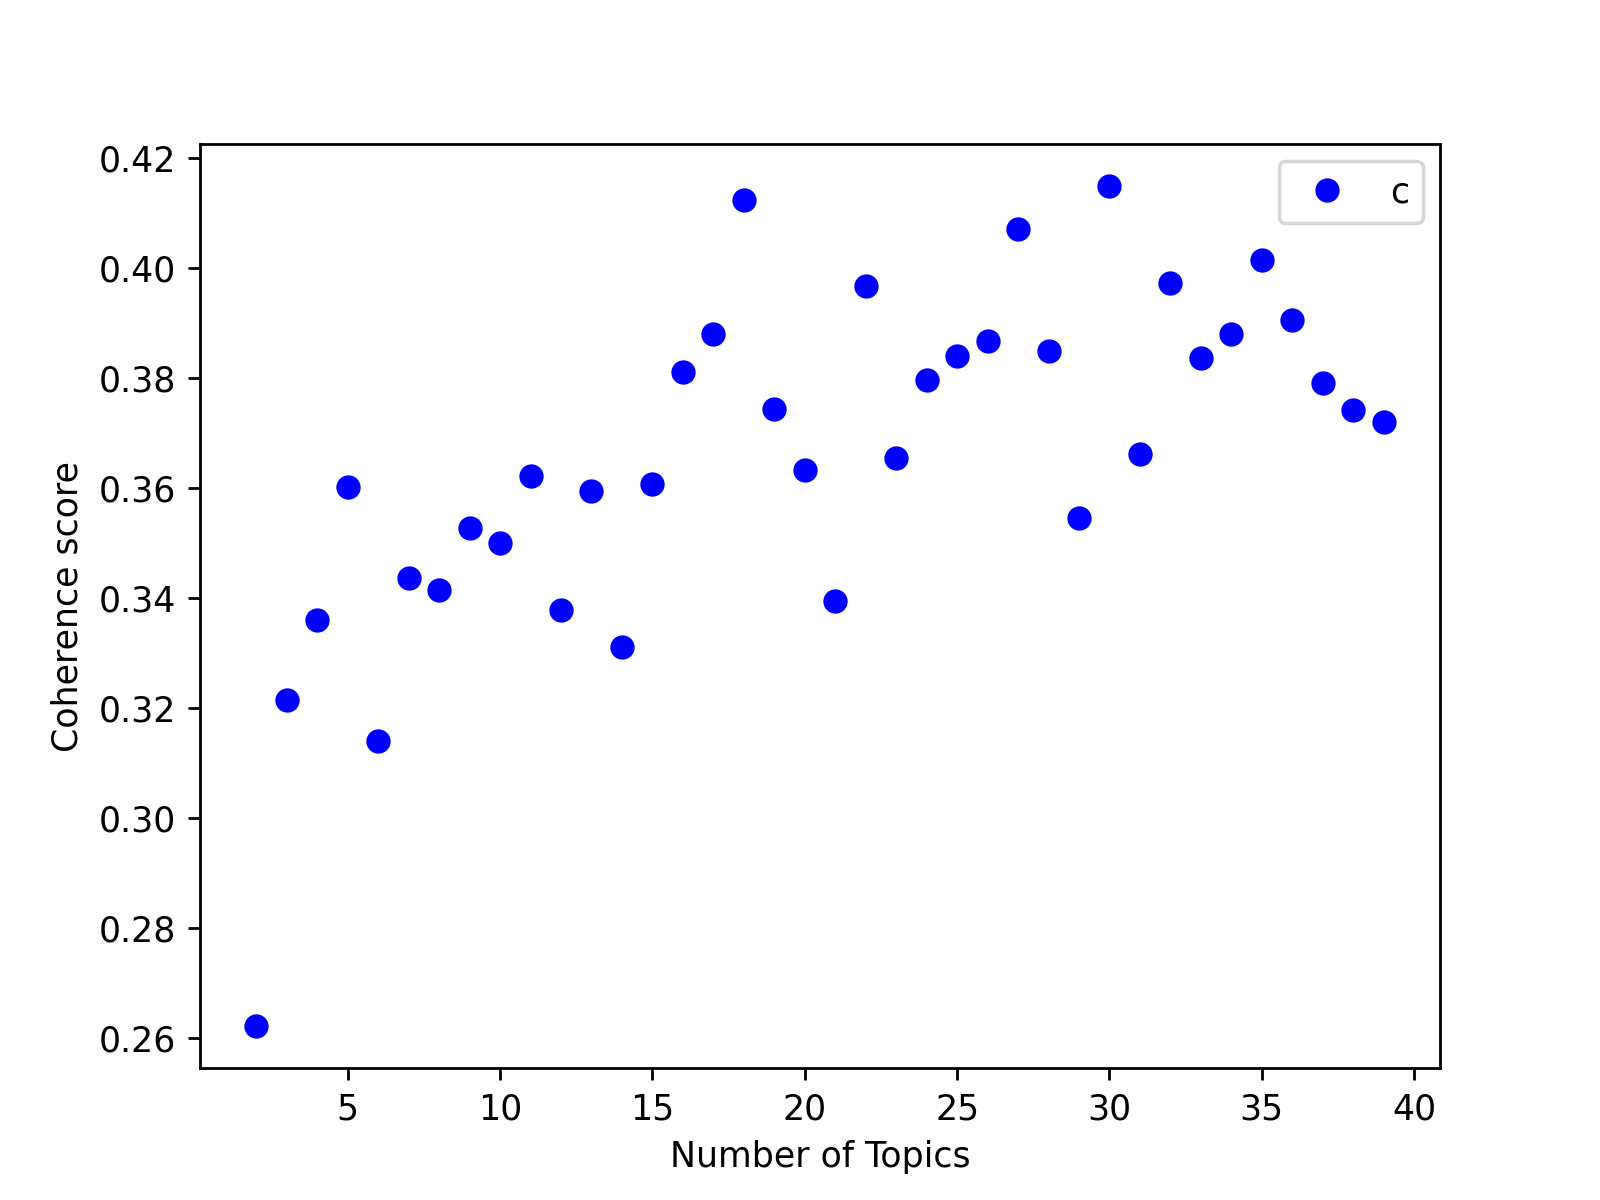

In [94]:
plt.figure(10)
# Show graph
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values,'bo')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Figure 10 shows the Coherence scores for various number of Topics. I think 'num_topics = 18' gives us the highest coherence score.

### 1.A Dominant Topics and Relevant Keywords

Something interesting we can now do is to look at each document (email) to assess the dominant topic and related keywords.
This could be useful in a text summarization or topic labeling task.

In [97]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [99]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

In [109]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(15)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0             0             4.0              0.2692   
1             1            17.0              0.9677   
2             2            17.0              0.4336   
3             3            13.0              0.4323   
4             4            17.0              0.3972   
5             5             3.0              0.3108   
6             6            13.0              0.5211   
7             7            14.0              0.2964   
8             8            13.0              0.3908   
9             9            12.0              0.7659   
10           10            13.0              0.2478   
11           11             0.0              0.8726   
12           12             9.0              0.6683   
13           13             9.0              0.6683   
14           14            17.0              0.7388   

                                             Keywords  \
0   forecast, weather, temperature, decline, incre...   
1   would, work, go, may, phillip, plan, time, let...   
2   would, work, go, may, phillip, plan, time, let...   
3   thank, mail, send, receive, need, phillip, ema...   
4   would, work, go, may, phillip, plan, time, let...   
5   week, new, last, phillip, property, back, know...   
6   thank, mail, send, receive, need, phillip, ema...   
7   power, fall, utility, new, forward, get, front...   
8   thank, mail, send, receive, need, phillip, ema...   
9   price, market, gas, say, power, high, demand, ...   
10  thank, mail, send, receive, need, phillip, ema...   
11  file, check, get, date, attach, list, see, ema...   
12  trade, position, buy, physical, socal, change,...   
13  trade, position, buy, physical, socal, change,...   
14  would, work, go, may, phillip, plan, time, let...   

                                                 Text  
0                           Here is our forecast\n\n   
1   Traveling to have a business meeting takes the...  
2                      test successful.  way to go!!!  
3   Randy,\n\n Can you send me a schedule of the s...  
4                 Let's shoot for Tuesday at 11:45.    
5   Greg,\n\n How about either next Tuesday or Thu...  
6   Please cc the following distribution list with...  
7                    any morning between 10 and 11:30  
8   1. login:  pallen pw: ke9davis\n\n I don't thi...  
9   ---------------------- Forwarded by Phillip K ...  
10  Mr. Buckner,\n\n For delivered gas behind San ...  
11  Lucy,\n\n Here are the rentrolls:\n\n\n\n Open...  
12  ---------------------- Forwarded by Phillip K ...  
13  ---------------------- Forwarded by Phillip K ...  
14  Dave, \n\n Here are the names of the west desk...

In [104]:
df_dominant_topic.Keywords.iloc[1]

'would, work, go, may, phillip, plan, time, let, want, think'

In [105]:
df_dominant_topic.Text.iloc[1]

"Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.  \n\nMy suggestion for where to go is Austin.  Play golf and rent a ski boat and jet ski's.  Flying somewhere takes too much time.\n"

### 1.B Best Email For a Given Topic

Now, imagine we pick a topic like 'trade', we might want to find out which email is most relevant to that topic.
Below, we peek into topics while highlighting the keywords and the email best representative of that topic.

In [106]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

In [107]:
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

In [108]:
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

sent_topics_sorteddf

Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.9462   
1         1.0              0.6275   
2         3.0              0.8294   
3         4.0              0.2692   
4         5.0              0.7341   
5         6.0              0.9836   
6         7.0              0.8710   
7         9.0              0.9070   
8        10.0              0.8719   
9        11.0              0.9495   
10       12.0              0.7659   
11       13.0              0.9792   
12       14.0              0.6302   
13       15.0              0.9383   
14       16.0              0.9957   
15       17.0              0.9677   

                                             Keywords  \
0   file, check, get, date, attach, list, see, ema...   
1   http_www, pay, notice, stay, tenant, go, apart...   
2   week, new, last, phillip, property, back, know...   
3   forecast, weather, temperature, decline, incre...   
4   response, meeting, storage, region, start, pm,...   
5   access, web, enronxgate, available, name, desk...   
6   tomorrow, call, program, question, report, tod...   
7   trade, position, buy, physical, socal, change,...   
8   basis, gas, follow, spread, index, average, da...   
9   sheet, get, talk, column, sign, let, course, a...   
10  price, market, gas, say, power, high, demand, ...   
11  thank, mail, send, receive, need, phillip, ema...   
12  power, fall, utility, new, forward, get, front...   
13  request, forward, gas, pdx, update, attach, re...   
14  cost, loan, would, project, land, construction...   
15  would, work, go, may, phillip, plan, time, let...   

                                                 Text  
0   \n---------------------- Forwarded by Phillip ...  
1   ---------------------- Forwarded by Phillip K ...  
2   Jeff,\n\n I received the rent roll.  I am goin...  
3                           Here is our forecast\n\n   
4   ---------------------- Forwarded by Phillip K ...  
5   ---------------------- Forwarded by Phillip K ...  
6   ---------------------- Forwarded by Phillip K ...  
7   Liane,\n\n As we discussed yesterday, I am con...  
8   Mark,\n\n Attached is a spreadsheet that lists...  
9   Lucy,\n\n The rent roll spreadsheet is startin...  
10  ---------------------- Forwarded by Phillip K ...  
11  ---------------------- Forwarded by Phillip K ...  
12  ---------------------- Forwarded by Phillip K ...  
13  ---------------------- Forwarded by Phillip K ...  
14  ---------------------- Forwarded by Phillip K ...  
15  Traveling to have a business meeting takes the...

# Use Case 2:

## Clustering Emails and Turning Them Into Insights

### Performing Kmeans clustering
Note: here I would use TF-IDF approach for analysing text.

In [211]:
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.5, min_df=2)

In [212]:
X = vect.fit_transform(df.content)
features = vect.get_feature_names()

<IPython.core.display.Javascript object>


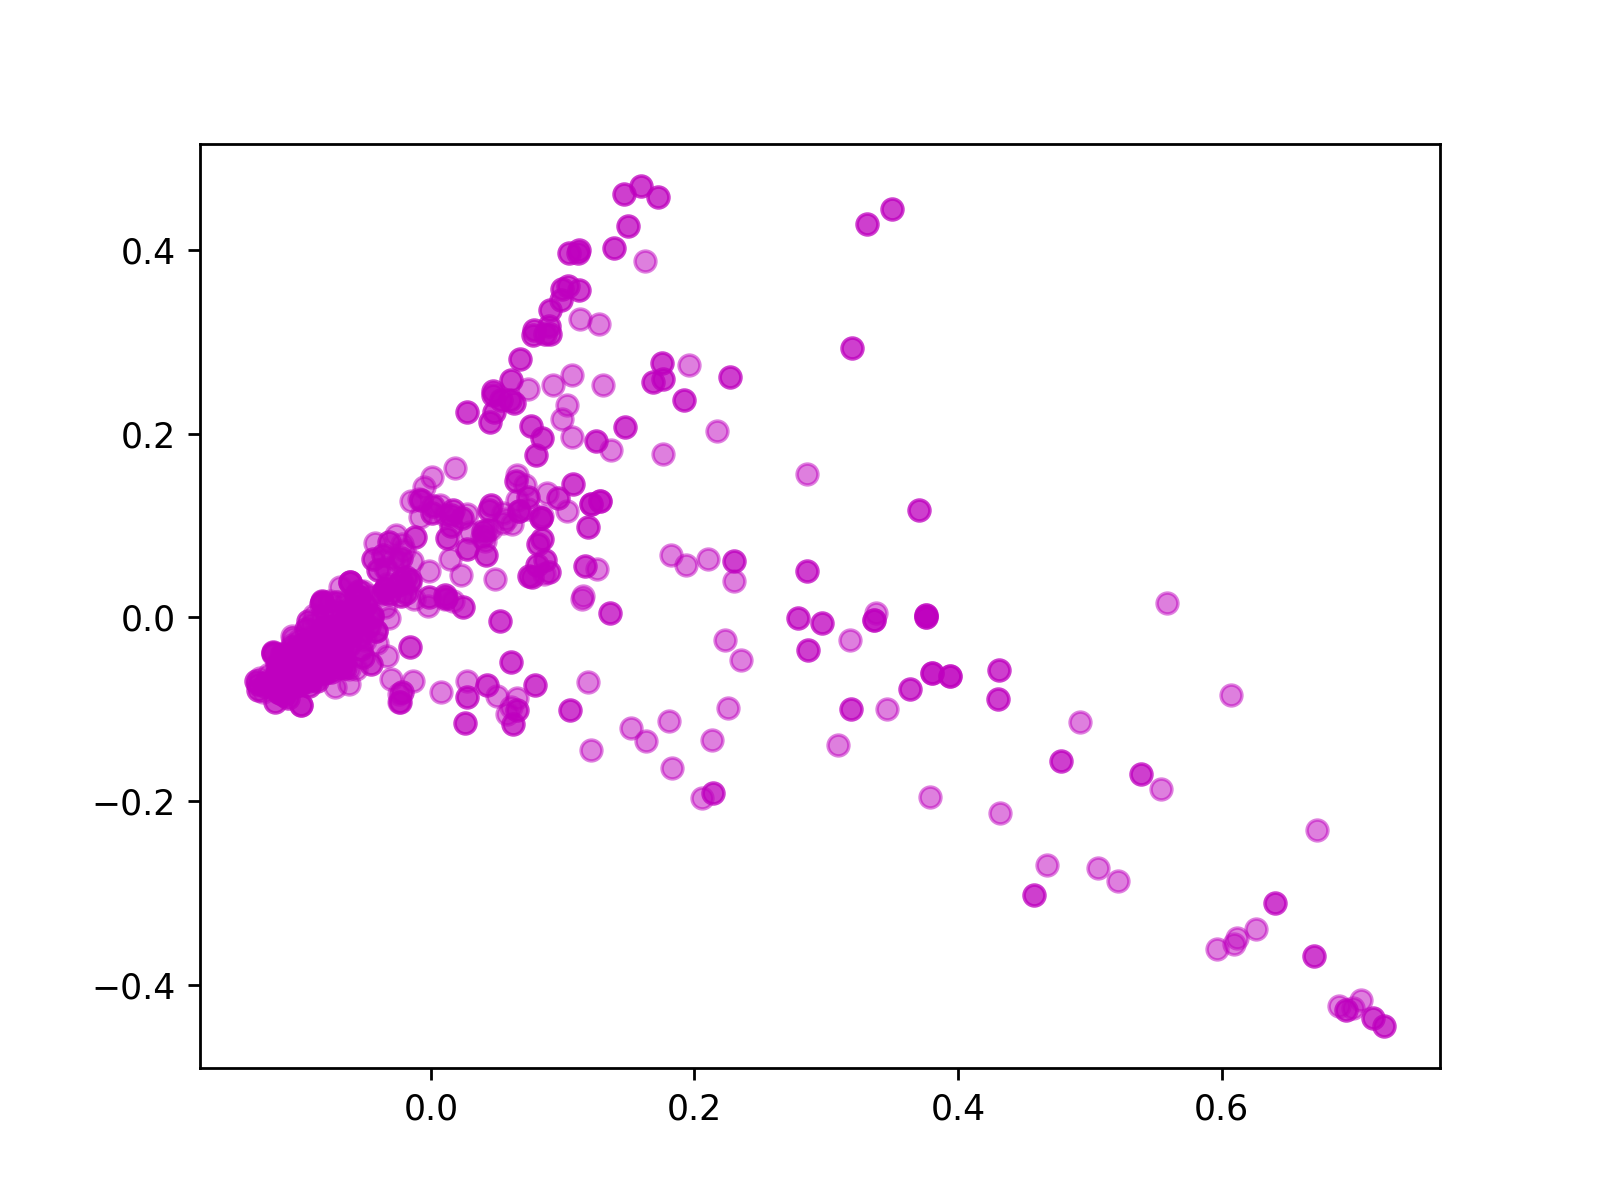

In [214]:
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)

plt.figure(12)
plt.scatter(coords[:, 0], coords[:, 1], c='m', alpha=0.5)
plt.show()

Figure 12 shows a 2d representation of the document-term matrix.

I wanted to find out what the top keywords were in those emails.

In [215]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [216]:
features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 20))

      features     score
0     meetings  0.426797
1         trip  0.338595
2     business  0.332853
3          ski  0.243930
4        takes  0.221169
5          try  0.144016
6       flying  0.126286
7       speaks  0.126286
8          jet  0.126286
9       honest  0.126286
10   stimulate  0.126286
11  productive  0.126286
12   presenter  0.126286
13        boat  0.126286
14    opinions  0.121965
15  suggestion  0.121965
16     prepare  0.118435
17       quiet  0.118435
18     suggest  0.115450
19     holding  0.115450


In [217]:
def top_mean_feats(X, features,
 grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [218]:
print(top_mean_feats(X, features, top_n=10))

  features     score
0    enron  0.043060
1     2000  0.022071
2    allen  0.020100
3     2001  0.015107
4       03  0.011947
5    email  0.011634
6      gas  0.011347
7     need  0.010702
8     lucy  0.010687
9  meeting  0.010606


In [227]:
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1, random_state=42)
labels = clf.fit_predict(X)

<IPython.core.display.Javascript object>


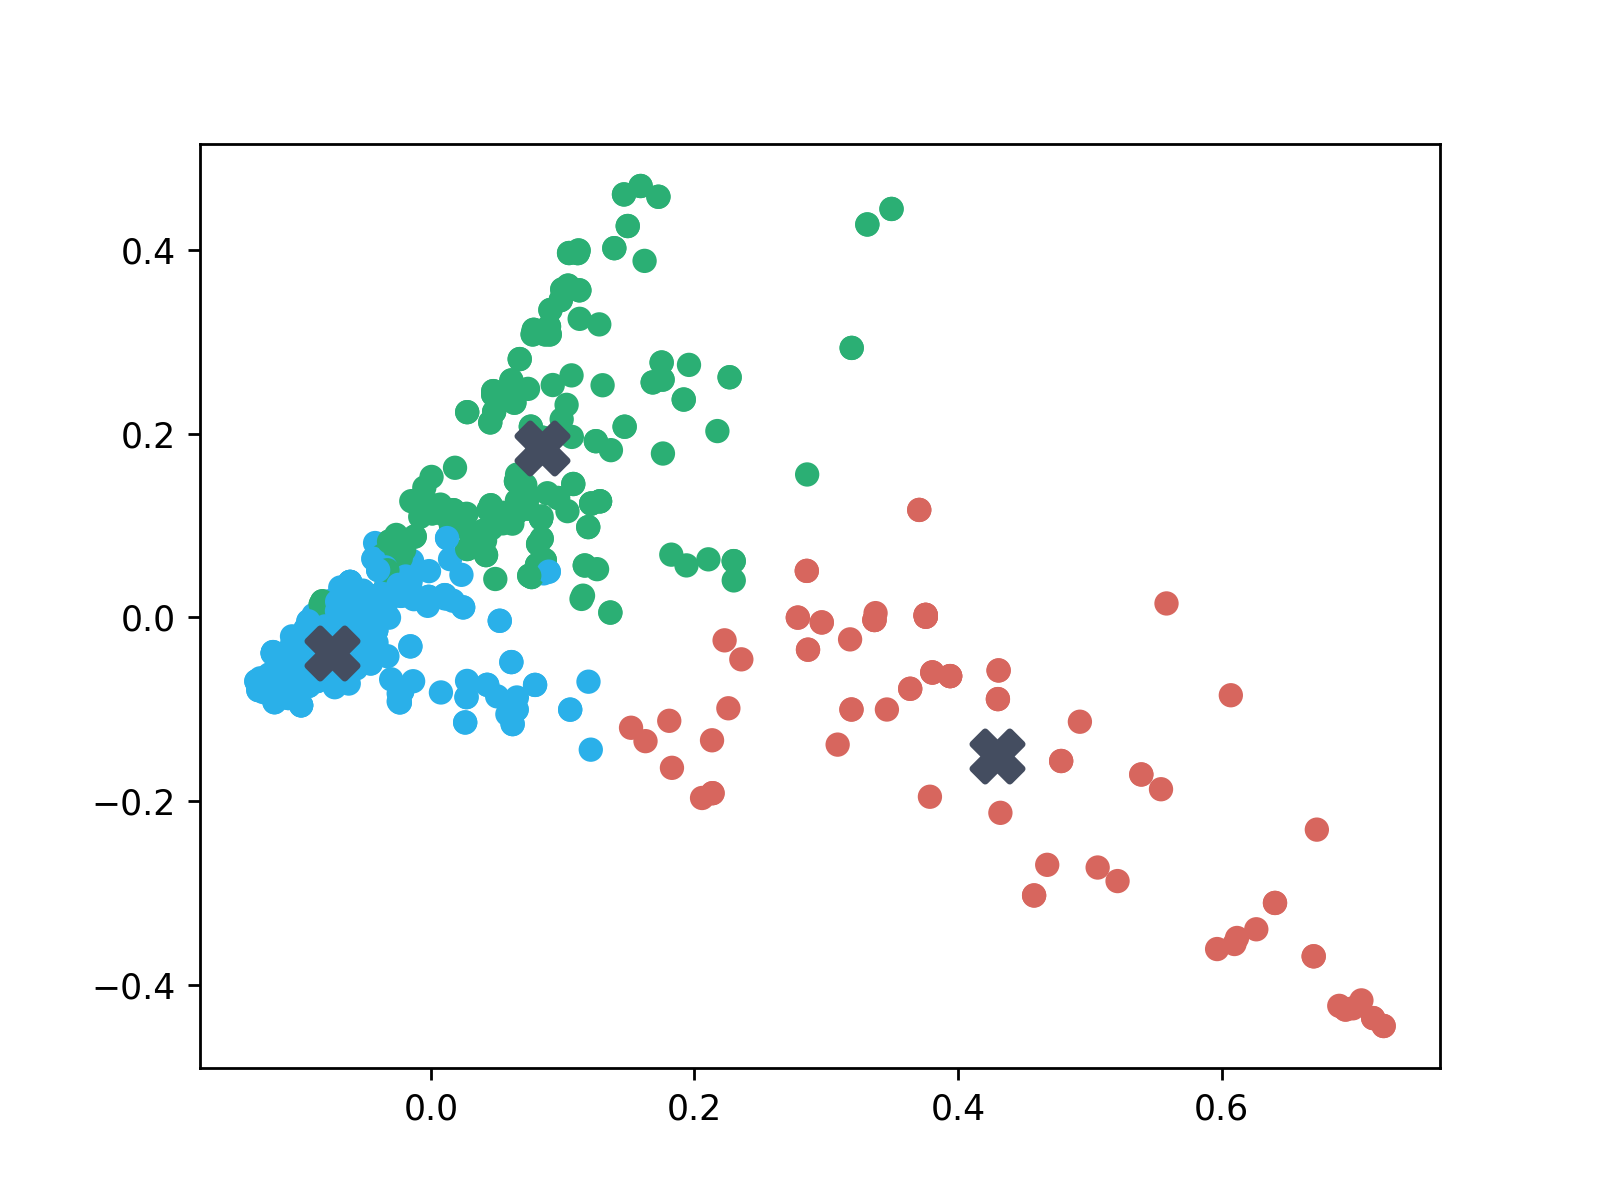

In [229]:
# Let's plot this with matplotlib to visualize it.
# First we need to make 2D coordinates from the sparse matrix.
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]

plt.figure(13)
plt.scatter(coords[:, 0], coords[:, 1], c=colors)
# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
plt.show()

Figure 13 shows three clusters in different colors. Centroids are maked with the cross sign.  

In [241]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=15):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

Note: Instead of printing out the terms, I found a great example on how to plot this graph with matlibplot. 
So I copied the function, made some adjustments and came up with this plot.

In [242]:
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

<IPython.core.display.Javascript object>


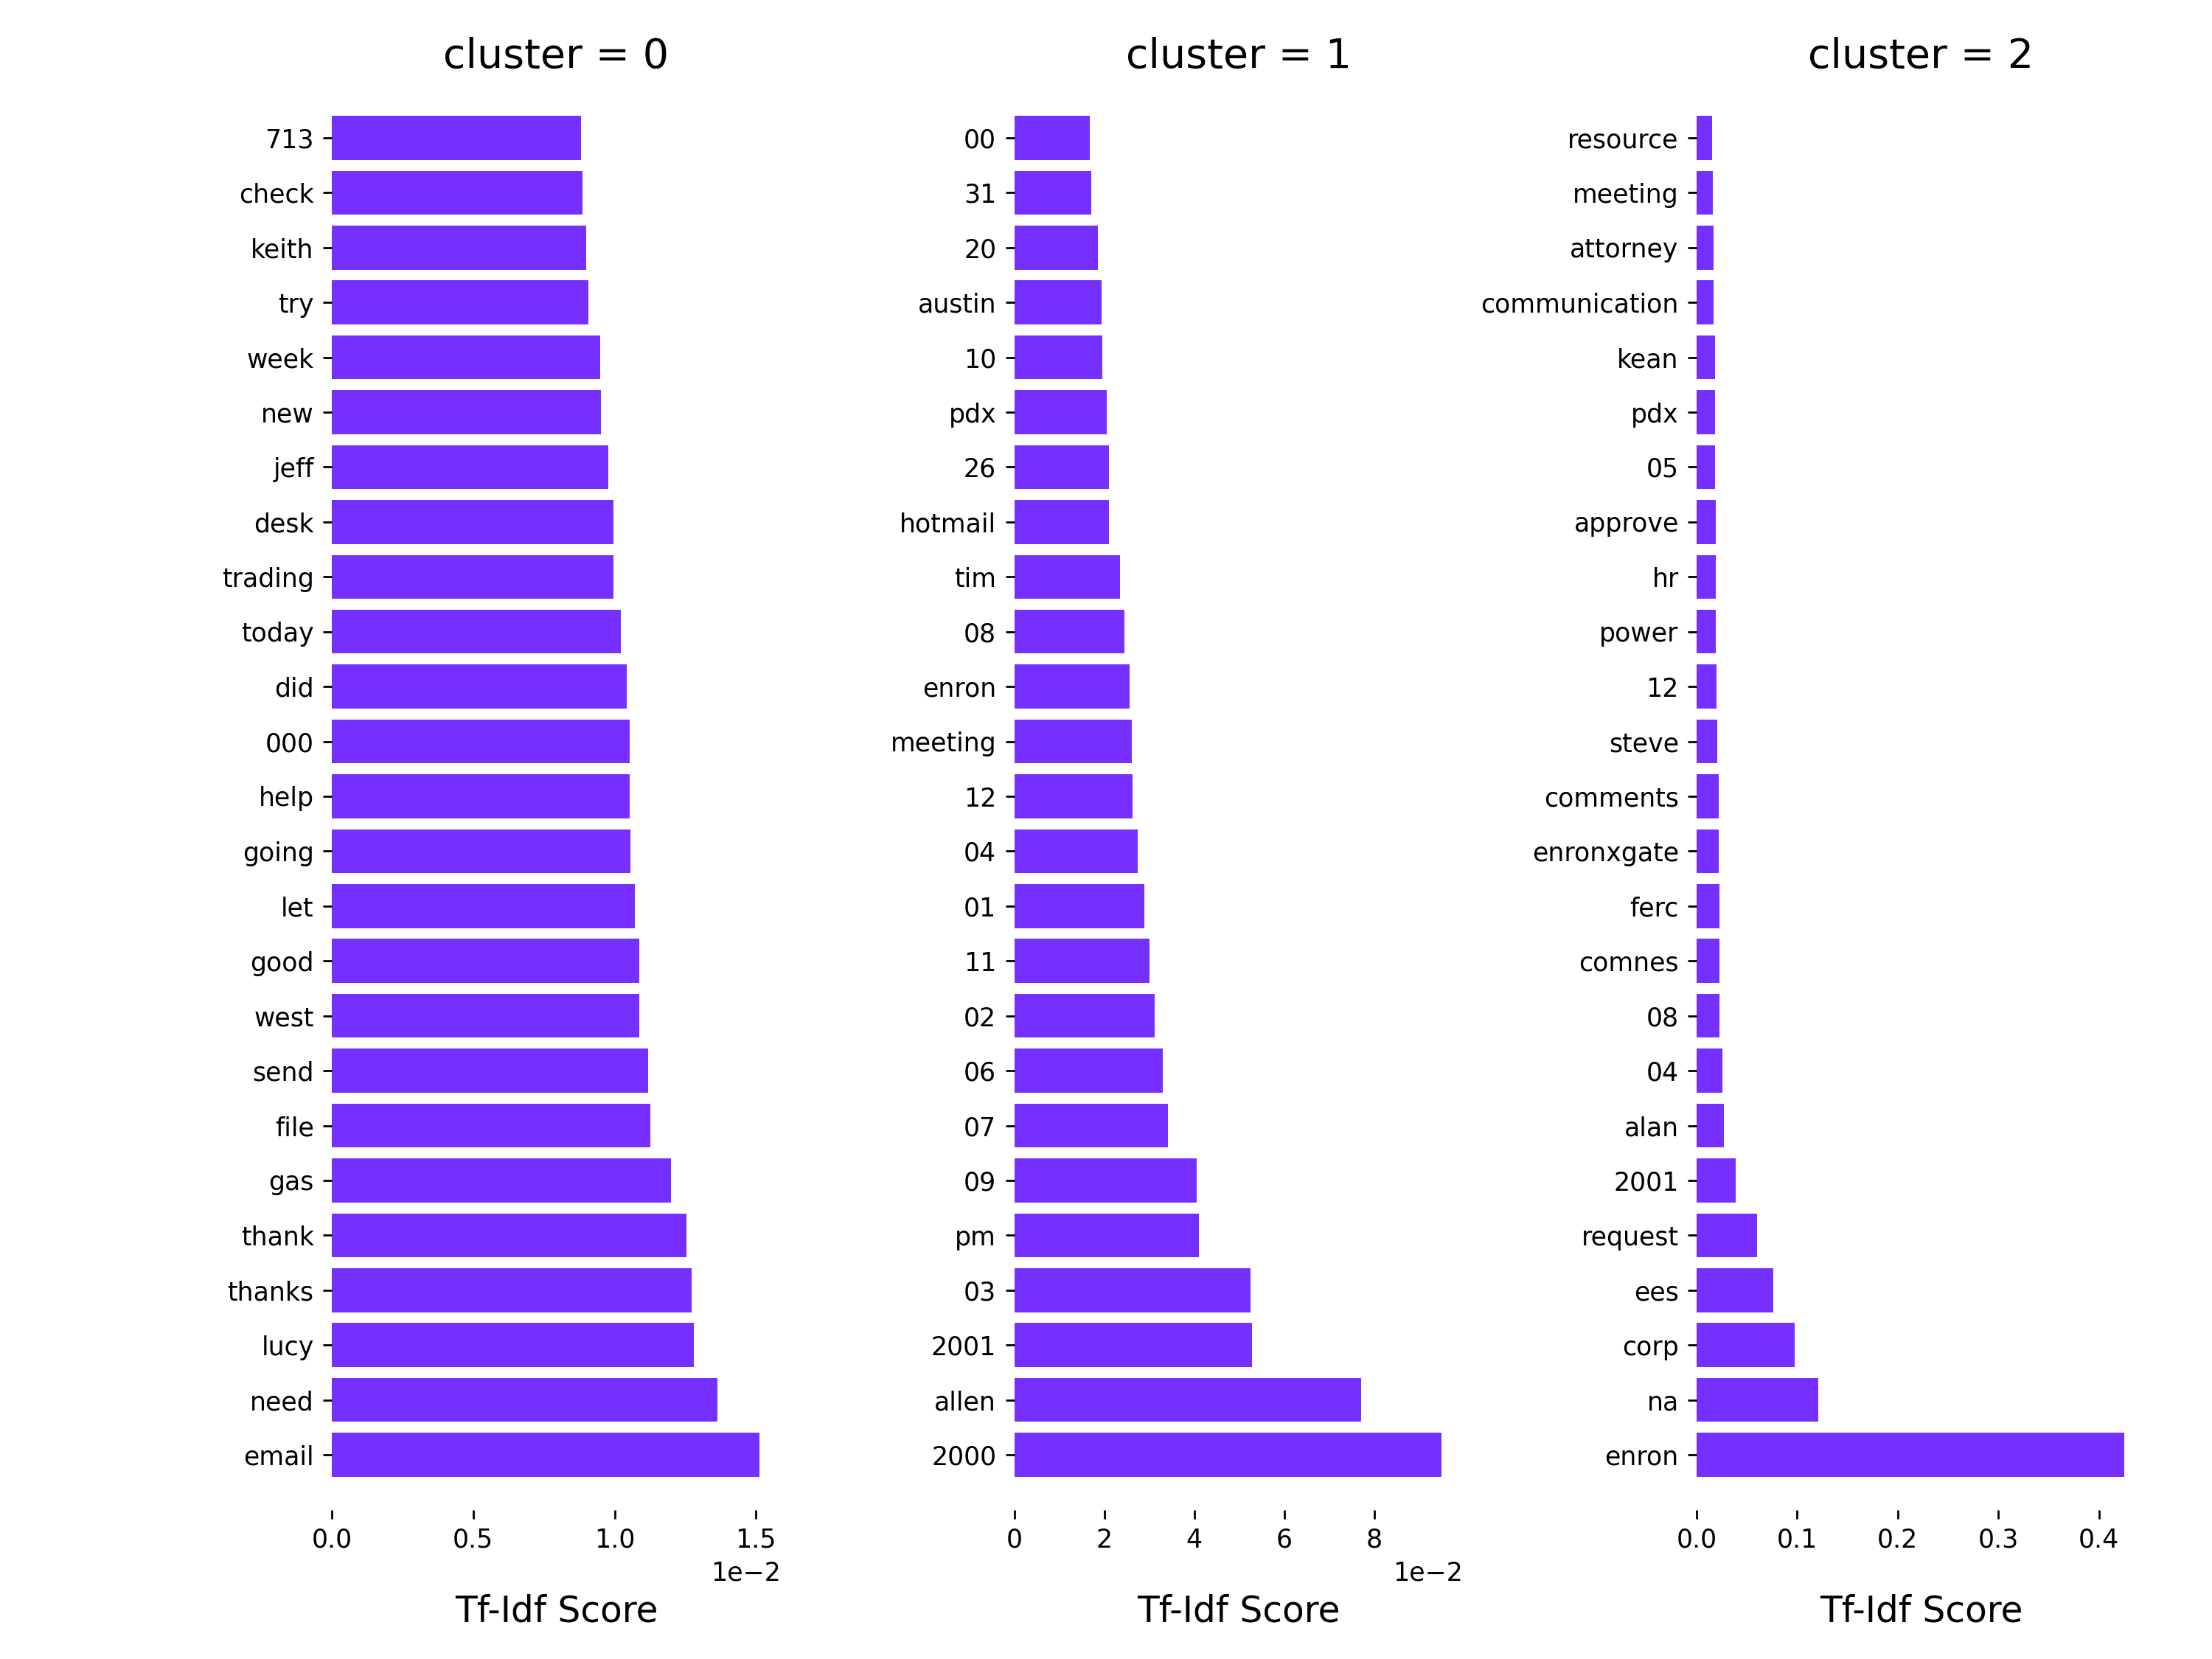

In [243]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

### 2.A Finding Related Emails to a Specific Query

After discovering the most popular terms and the most exciting emails due to clustering algorithms, I was looking for a way to further group emails related to a specific keyword.

Instead of finding emails related to each other, I want to see emails pertaining to a “query” (e.g., a specific keyword or term) that I can specify. Let’s say I want to find all the related emails to one of the top terms in the clusters, “salary” for example, in that case, I need to make a separate vector from the query (salary) that will fit into the original vector. I would use the concept of 'Cosine Similarity' for this task.

In [128]:
from sklearn.metrics.pairwise import linear_kernel

#### To make the code more reusable, I created a class that could quickly lookup any term or query I want.

In [129]:
class EmailDataset: 
  def __init__(self):
    stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
    self.vec = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
    self.emails = df.content

    # train on the given email data.
    self.train()
  
  def train(self):
    self.vec_train = self.vec.fit_transform(self.emails)
  
  def query(self, keyword, limit):
    vec_keyword = self.vec.transform([keyword])
    cosine_sim = linear_kernel(vec_keyword, self.vec_train).flatten()
    related_email_indices = cosine_sim.argsort()[:-limit:-1]
    return related_email_indices

  def find_email_by_index(self, i):
    return self.emails[i]

In [130]:
ds = EmailDataset()
results = ds.query('salary', 100)
# print out the first result.
print(ds.find_email_by_index(results[0]))

Randy,

 Can you send me a schedule of the salary and level of everyone in the 
scheduling group.  Plus your thoughts on any changes that need to be made.  
(Patti S for example)

Phillip
